# Modules

In [2]:
from MyModule import *

In [3]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# # , , , 
# %matplotlib widget 
# plt.ioff()

In [ ]:
'''
qt for popup window (savable as pdf, svg...)
inline for inline plot
notebook for interactive plot
widget for interactive plot
'''

# Fonctions

## Raster

In [5]:
def plotRaster(AllData, animal, condition, direction, unit, color='black', xlabel='Time (s)', ylabel='# Trial', extra=None, title='', plotvelocity=False, velocitycolor='k', velocityalpha=0.13, save=False, filename='Raster.png', show=True, xlim=None, ylim=None):
    if type(unit)==list:
        spikeTimesObject = np.concatenate([[AllData[animal]['Spiking_times']['SpikeTimes'][condition][direction_i][unit_i] for unit_i in unit] for direction_i in direction])
    else:
        spikeTimesObject = AllData[animal]['Spiking_times']['SpikeTimes'][condition][direction][unit]

    timeBef, timeAft = AllData[animal]['informative_data']['timeBef'], AllData[animal]['informative_data']['timeAft']
    if plotvelocity:
        rotationSpeed = AllData[animal]['informative_data']['rotationSpeed']
        duration = AllData[animal]['Rotation_data']['duration']
        MeanRotation = AllData[animal]['Rotation_data']['MeanRotation'][condition][direction]

    linelengths = 1
    
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    
    if xlim!=None:
        plt.xlim(xlim)
    else:
        plt.xlim(-timeBef,timeAft)
    

    ### annulate the offset due to python indexation
    def custom_formatter(x, pos):
        return f"{int(x) + 1}"
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))

    if ylim!=None:
        plt.ylim(ylim)
    else:
        plt.ylim(0-linelengths/2,len(spikeTimesObject)-1+linelengths/2)
    # plt.grid(False)

    if plotvelocity:
        normalization = 1/rotationSpeed*len(spikeTimesObject)
        
        if min(MeanRotation) < -rotationSpeed/2:
            MeanRotation = MeanRotation * normalization - min(MeanRotation * normalization) - linelengths/2
            haxis = len(spikeTimesObject)*np.ones(len(duration))
        else:
            MeanRotation = MeanRotation * normalization - linelengths/2
            haxis = np.zeros(len(duration)) - linelengths/2
        plt.plot(duration, MeanRotation, color=velocitycolor, alpha=velocityalpha)
        plt.fill_between(duration, MeanRotation, haxis, color=velocitycolor, alpha=velocityalpha*0.8)
        
    plt.eventplot(spikeTimesObject, linelengths=linelengths, colors=color)
    
    if extra is not None:
        if type(extra)==list:
            for ex in extra:
                ex
        else:
            extra

    plt.title(title)

    if save:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    elif show:
        plt.show()

## PSTH

In [6]:
def plotPSTH(AllData, animal, condition, direction, unit, plotvelocity=False, color='k',shadedcolor='c',binResolution = 0.03,xlabel=True,ylabel=True, title='', save=False, filename='PSTH.png', show=True, velocitycolor='red', velocityalpha=0.13, extra=None, xlim=None, ylim=None):

    if type(unit)==list:
        StudiedSpikeTimes = np.concatenate([AllData[animal]['Spiking_times']['SpikeTimes'][condition][direction][unit_i] for unit_i in unit])
    else:
        StudiedSpikeTimes = AllData[animal]['Spiking_times']['SpikeTimes'][condition][direction][unit]

    timeBef, timeAft = AllData[animal]['informative_data']['timeBef'], AllData[animal]['informative_data']['timeAft']
    if plotvelocity:
        rotationSpeed = AllData[animal]['informative_data']['rotationSpeed']
        duration = AllData[animal]['Rotation_data']['duration']
        MeanRotation = AllData[animal]['Rotation_data']['MeanRotation'][condition][direction]

    
    local_trial_number = len(StudiedSpikeTimes)

    spike_number_per_trial = [[] for _ in range(local_trial_number)]
    edges = []

    for trial in range(local_trial_number):
        spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

    frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
    mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

    Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
    Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
    SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))


    if plotvelocity:
        normalization = 1/rotationSpeed*max(abs(Zscore))
        
        if min(MeanRotation) < -rotationSpeed/2:
            MeanRotation = MeanRotation * normalization
            haxis = np.zeros(len(duration))
        else:
            MeanRotation = MeanRotation * normalization
            haxis = np.zeros(len(duration))
        plt.plot(duration, MeanRotation, color=velocitycolor, alpha=velocityalpha)
        plt.fill_between(duration, MeanRotation, haxis, color=velocitycolor, alpha=velocityalpha*0.8)

    # plt.figure(figsize=(15,6))
    plt.plot(edges[:-1], Zscore, color=color)
    plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)

    if xlim!=None:
        plt.xlim(xlim)
    else:
        plt.xlim(-timeBef,timeAft)
    if ylim!=None:
        plt.ylim(ylim)
    if ylabel:
        plt.ylabel('Z-Score FR')
    if xlabel:
        plt.xlabel('Time (s)')
    plt.grid(False)

    plt.title(title)

    if extra is not None:
        if type(extra)==list:
            for ex in extra:
                ex
        else:
            extra
            
    if save:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    elif show:
        plt.show()

## vMI fonction

In [7]:
def vMI_function(AllData, filename='', path='', save=False, show=True, s=100,alpha=0.6, scale=0.008, ML=True, AP=True, CW=True, CCW=True, stats=False, hist=False, interest=None, color='c', binsNumber=30):
    # INITIATION
    stereotaxic_title=[]
    stereotaxic_label=[]
    direction_selected=[]
    if ML:
        stereotaxic_title.append('Mediolateral')
        stereotaxic_label.append('ML_pos')
    if AP:
        stereotaxic_title.append('Anteroposterior')
        stereotaxic_label.append('AP_pos')
    if CW:
        direction_selected.append('CW')
    if CCW:
        direction_selected.append('CCW')

    modulation_quantity = dict() if (stats and hist) else None


    # LOOPS
    for pos_title, posOrientation in zip(stereotaxic_title, stereotaxic_label):
        for condition in ['second']:
            for direction in direction_selected:

                # IMPORTATION OF DATA
                NtotClust = np.sum([AllData[animal]['SUA_data']['Nclust'] for animal in AllData])
                AllDepth = np.concatenate([AllData[animal]['MUA_data']['AllDepth'] for animal in AllData])
                vMI = np.concatenate([AllData[animal]['Statistics_data']['vMI'][condition][direction] for animal in AllData])
                pos = [AllData[animal]['informative_data'][posOrientation] for animal in AllData]
                position = np.concatenate([np.random.normal(loc=pos[i], scale=scale, size=(AllData[animal]['SUA_data']['Nclust'], 1)) for animal, i in zip(AllData, range(len(pos)))])


                maximum_value = max([max(AllData[animal]['Statistics_data']['vMI'][condition][direction]) for animal in AllData])
                minimum_value = min([min(AllData[animal]['Statistics_data']['vMI'][condition][direction]) for animal in AllData])
                nul_value = min([min(AllData[animal]['Statistics_data']['vMI'][condition][direction], key=lambda x: abs(x)) for animal in AllData])


                

                # CREATING DATA FOR PLOT
                if stats:
                    AllHow = np.concatenate([[AllData[animal]['Statistics_data']['modulation']['second'][unit]['type'] for unit in range(AllData[animal]['SUA_data']['Nclust'])] for animal in AllData])
                    AllWho = np.concatenate([[AllData[animal]['Statistics_data']['modulation']['second'][unit]['selectivity'] for unit in range(AllData[animal]['SUA_data']['Nclust'])] for animal in AllData])

                    condition_positive, condition_negative, condition_unmodulated = [], [], []

                    if direction == 'CW':
                        for i in range(NtotClust):
                            condition_positive.append((AllWho[i] == 'CW' or AllWho[i] == 'both') and (AllHow[i] == '+' or AllHow[i] == '+/+' or AllHow[i] == '+/-'))
                            condition_negative.append((AllWho[i] == 'CW' or AllWho[i] == 'both') and (AllHow[i] == '-' or AllHow[i] == '-/+' or AllHow[i] == '-/-'))
                            condition_unmodulated.append(AllWho[i] == 'unmodulated' or AllWho[i] == 'CCW')
                    elif direction == 'CCW':
                        for i in range(NtotClust):
                            condition_positive.append((AllWho[i] == 'CCW' or AllWho[i] == 'both') and (AllHow[i] == '+' or AllHow[i] == '+/+' or AllHow[i] == '-/+'))
                            condition_negative.append((AllWho[i] == 'CCW' or AllWho[i] == 'both') and (AllHow[i] == '-' or AllHow[i] == '+/-' or AllHow[i] == '-/-'))
                            condition_unmodulated.append(AllWho[i] == 'unmodulated' or AllWho[i] == 'CW')


                    positionSigni_P = [position[i] for i in range(NtotClust) if condition_positive[i]]
                    depthSigni_P = [AllDepth[i] for i in range(NtotClust) if condition_positive[i]]
                    vMISigni_P = [vMI[i] for i in range(NtotClust) if condition_positive[i]]

                    positionSigni_N = [position[i] for i in range(NtotClust) if condition_negative[i]]
                    depthSigni_N = [AllDepth[i] for i in range(NtotClust) if condition_negative[i]]
                    vMISigni_N = [vMI[i] for i in range(NtotClust) if condition_negative[i]]

                    positionNot = [position[i] for i in range(NtotClust) if condition_unmodulated[i]]
                    depthNot = [AllDepth[i] for i in range(NtotClust) if condition_unmodulated[i]]
                    vMINot = [vMI[i] for i in range(NtotClust) if condition_unmodulated[i]]

                    positionData = [positionSigni_P, positionSigni_N, positionNot]
                    depthData = [depthSigni_P, depthSigni_N, depthNot]
                    vMIData = [vMISigni_P, vMISigni_N, vMINot]

                    if hist:
                        histdata2 = [] ; bins2 = [] ; histdataDist2 = []
                        histdata3 = [] ; bins3 = [] ; histdataDist3 = []

                        for data in [depthSigni_P, depthSigni_N]:
                            histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                            histdata2.append(histdatafoo) ; bins2.append(binsfoo)
                            histdataDist2.append(histdatafoo / NtotClust)

                        for data in [positionSigni_P, positionSigni_N]:
                            histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                            histdata3.append(histdatafoo) ; bins3.append(binsfoo)
                            histdataDist3.append(histdatafoo / NtotClust)

                        modulation_label = ['Excitation', 'Suppression', 'No modulation']
                        modulation_quantity[direction] = [len(positionSigni_P), len(positionSigni_N), len(positionNot)]
                elif not stats:
                    if hist:
                        histdata3, bins3 = np.histogram(position, bins=binsNumber)
                        histdataDist3 = histdata3 / NtotClust

                        histdata2, bins2 = np.histogram(AllDepth, bins=binsNumber)
                        histdataDist2 = histdata2 / NtotClust

                    positionData = position
                    depthData = AllDepth
                    vMIData = vMI
                ############################################################





                # mettre en évidence les neurones d'intérêt
                if interest!=None:
                    wanted_array = []
                    for value in interest:
                        if value == 'max':
                            wanted_array.append(maximum_value)
                        elif value == 'min':
                            wanted_array.append(minimum_value)
                        elif value == 'nul':
                            wanted_array.append(nul_value)
                        else:
                            wanted_array.append(value)
                ############################################################





                # PLOTTING DATA
                fig = plt.figure(figsize=(15.5, 9))

                ## Creating axis
                if hist:
                    gs = GridSpec(nrows=4, ncols=4)
                    ax1 = fig.add_subplot(gs[1:4,0:3]) ; # scatter plot on the left
                    ax2 = fig.add_subplot(gs[1:4,3], sharey=ax1) ;  # histogram on the right
                    ax3 = fig.add_subplot(gs[0,0:3], sharex=ax1) ;  # histogram on the top
                    ax4 = fig.add_subplot(gs[0,3]) if stats else None
                ############################################################




                ## Highlighting units of interest
                if interest!=None:
                    for value in wanted_array:
                        ax = ax1 if hist else plt
                        if type(value) == list:
                            values_of_interest = [vMI_value for vMI_value in vMI if value[0] <= vMI_value <= value[1]]
                            for value in values_of_interest:
                                unit_index = np.where(vMI == value)[0]
                                ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2) if len(unit_index) > 0 else None
                        else:
                            unit_index = np.where(vMI == value)[0]
                            if len(unit_index) > 0:
                                ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2)
                ############################################################




                ## Plots of data
                if stats:                    
                    if hist:
                        for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['Excited units', 'Suppressed units', 'Non-significant modulation']):
                            ax1.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                        ax1.legend()
                        for histdata, bins, color in zip(histdataDist2, bins2, ['red', 'blue']):
                            ax2.plot(histdata, bins[:-1], color=color)
                        for histdata, bins, color in zip(histdataDist3, bins3, ['red', 'blue']):
                            ax3.plot(bins[:-1], histdata, color=color)
                        ax4.bar(modulation_label, modulation_quantity[direction], color=['red', 'blue', 'grey'], alpha=1)
                    else:
                        for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['Excited units', 'Suppressed units', 'Non-significant modulation']):
                            plt.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                        plt.legend()
                else:
                    if hist:
                        ax1.scatter(positionData, depthData, s=s, alpha=alpha, color=color)
                        ax2.plot(histdataDist2, bins2[:-1], color=color)
                        ax3.plot(bins3[:-1], histdataDist3, color=color)
                    else:
                        plt.scatter(positionData, depthData, c=vMI, cmap='coolwarm', s=s, alpha=alpha, clim=(minimum_value, maximum_value))                
                        plt.colorbar(label=f"{direction} modulation index"+r" : $\frac{n_{during} - n_{before}}{n_{during} + n_{before}}$") if ((not hist) and (not stats)) else None


                ## MEP
                xlabel = f"{pos_title} position (mm)"
                ylabel = r"Depth ($\mu$m)"
                histlabel = 'Density' if hist else None
                statsylabel = 'Number of units' if stats else None
                suptitle = f"{direction} modulation of units in {pos_title} axis"

                xfontsize = 12
                yfontsize = 12
                histfontsize = 12 if hist else None
                statsyfontsize = 12 if stats else None
                suptitlefontsize = 16
                ############################################################

                ## Aesthetics
                if hist:
                    ax1.invert_yaxis()
                    ax1.invert_xaxis() if posOrientation == 'ML_pos' else None
                    ax1.set_xlabel(xlabel, fontsize=xfontsize)
                    ax1.set_ylabel(ylabel, fontsize=yfontsize)

                    ax2.set_xlabel(histlabel, fontsize=histfontsize)
                    ax2.spines['top'].set_visible(False)
                    ax2.spines['right'].set_visible(False) 
                    ax2.spines['bottom'].set_visible(True) 
                    ax2.spines['left'].set_visible(False)
                    ax2.tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False, labelleft=False, labelbottom=True)

                    ax3.set_ylabel(histlabel, fontsize=histfontsize)
                    ax3.spines['top'].set_visible(False)
                    ax3.spines['right'].set_visible(False)
                    ax3.spines['bottom'].set_visible(False)
                    ax3.spines['left'].set_visible(True)
                    ax3.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelleft=True, labelbottom=False)

                    if stats:
                        ax4.set_ylabel(statsylabel, fontsize=statsyfontsize)
                        ax4.set_xticks(np.arange(len(modulation_label)))
                        ax4.set_xticklabels(modulation_label, rotation=20)
                else:
                    plt.gca().invert_yaxis()
                    plt.gca().invert_xaxis() if posOrientation == 'ML_pos' else None
                    plt.xlabel(xlabel, fontsize=xfontsize)
                    plt.ylabel(ylabel, fontsize=yfontsize)
                        
                plt.suptitle(suptitle, fontsize=suptitlefontsize)
                ############################################################


                # Saving and showing
                if save:
                    if path=='':
                        KeyError('You must specify a path to save the figure')
                    else:
                        os.makedirs(path, exist_ok=True)
                        if filename:
                            plt.savefig(os.path.join(path , f"{direction}_modulation_{pos_title}_{filename}.png"))
                        else:
                            plt.savefig(os.path.join(path , f"{direction}_modulation_{pos_title}.png"))
                
                plt.show() if show else plt.close()
                ############################################################

                foo=dict()
                for animal in AllData:
                    foo[animal] = AllData[animal]['informative_data'][posOrientation]
                sorted_keys = [key for key, value in sorted(foo.items(), key=itemgetter(1))] 

                myTable = PrettyTable(["Animal", pos_title]) 

                for animal in sorted_keys:
                    myTable.add_row([animal, foo[animal]])

                print(myTable)

        if stats and hist:
            plotdata = pd.DataFrame({'CW':modulation_quantity['CW'], 'CCW':modulation_quantity['CCW']}, index=modulation_label)
            plotdata.plot(kind="bar",figsize=(10, 5), color=['red', 'blue'], rot=25)
            plt.ylabel('Number of units')
            plt.title('Modulation of units')
            if save:
                if path=='':
                    KeyError('You must specify a path to save the figure')
                else:
                    os.makedirs(path, exist_ok=True)
                    if filename:
                        plt.savefig(os.path.join(path , f"modulation_{pos_title}_barplot_{filename}.png"))
                    else:
                        plt.savefig(os.path.join(path , f"modulation_{pos_title}_barplot.png"))
            if show:
                plt.show()
            else:
                plt.close()
            print('\n')

## dirMI fonction

In [8]:
def dirMI_function(AllData, filename='', path='', save=False, show=True, s=100,alpha=0.6, scale=0.008, ML=True, AP=True, stats=False, hist=False, interest=None, color='c', binsNumber=30):
    # INITIATION
    stereotaxic_title=[]
    stereotaxic_label=[]
    if ML:
        stereotaxic_title.append('Mediolateral')
        stereotaxic_label.append('ML_pos')
    if AP:
        stereotaxic_title.append('Anteroposterior')
        stereotaxic_label.append('AP_pos')

    preference_quantity = dict() if (stats and hist) else None


    # LOOPS
    for pos_title, posOrientation in zip(stereotaxic_title, stereotaxic_label):
        for condition in ['second']:

            # IMPORTATION OF DATA
            NtotClust = np.sum([AllData[animal]['SUA_data']['Nclust'] for animal in AllData])
            AllDepth = np.concatenate([AllData[animal]['MUA_data']['AllDepth'] for animal in AllData])
            dirMI = np.concatenate([AllData[animal]['Statistics_data']['dirMI'][condition] for animal in AllData])
            pos = [AllData[animal]['informative_data'][posOrientation] for animal in AllData]
            position = np.concatenate([np.random.normal(loc=pos[i], scale=scale, size=(AllData[animal]['SUA_data']['Nclust'], 1)) for animal, i in zip(AllData, range(len(pos)))])


            maximum_value = max([max(AllData[animal]['Statistics_data']['dirMI'][condition]) for animal in AllData])
            minimum_value = min([min(AllData[animal]['Statistics_data']['dirMI'][condition]) for animal in AllData])
            nul_value = min([min(AllData[animal]['Statistics_data']['dirMI'][condition], key=lambda x: abs(x)) for animal in AllData])


            

            # CREATING DATA FOR PLOT
            if stats:
                AllPreferences = np.concatenate([[AllData[animal]['Statistics_data']['preference']['second'][unit] for unit in range(AllData[animal]['SUA_data']['Nclust'])] for animal in AllData])

                CW_preferrers_bool = AllPreferences == 'CW'
                CCW_preferrers_bool = AllPreferences == 'CCW'
                Non_preferrers_bool = AllPreferences == 'None'

                
                positionCW = [position[i] for i in range(NtotClust) if CW_preferrers_bool[i]]
                depthCW = [AllDepth[i] for i in range(NtotClust) if CW_preferrers_bool[i]]
                dirMICW = [dirMI[i] for i in range(NtotClust) if CW_preferrers_bool[i]]

                positionCCW = [position[i] for i in range(NtotClust) if CCW_preferrers_bool[i]]
                depthCCW = [AllDepth[i] for i in range(NtotClust) if CCW_preferrers_bool[i]]
                dirMICCW = [dirMI[i] for i in range(NtotClust) if CCW_preferrers_bool[i]]

                positionNone = [position[i] for i in range(NtotClust) if Non_preferrers_bool[i]]
                depthNone = [AllDepth[i] for i in range(NtotClust) if Non_preferrers_bool[i]]
                dirMINone = [dirMI[i] for i in range(NtotClust) if Non_preferrers_bool[i]]

                positionData = [positionCW, positionCCW, positionNone]
                depthData = [depthCW, depthCCW, depthNone]
                dirMIData = [dirMICW, dirMICCW, dirMINone]

                if hist:
                    histdata2 = [] ; bins2 = [] ; histdataDist2 = []
                    histdata3 = [] ; bins3 = [] ; histdataDist3 = []

                    for data in [depthCW, depthCCW]:
                        histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                        histdata2.append(histdatafoo) ; bins2.append(binsfoo)
                        histdataDist2.append(histdatafoo / NtotClust)

                    for data in [positionCW, positionCCW]:
                        histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                        histdata3.append(histdatafoo) ; bins3.append(binsfoo)
                        histdataDist3.append(histdatafoo / NtotClust)

                    modulation_label = ['CW-preferring', 'CCW-preferring', 'No preference']
                    preference_quantity = [len(positionCW), len(positionCCW), len(positionNone)]
            elif not stats:
                if hist:
                    histdata3, bins3 = np.histogram(position, bins=binsNumber)
                    histdataDist3 = histdata3 / NtotClust

                    histdata2, bins2 = np.histogram(AllDepth, bins=binsNumber)
                    histdataDist2 = histdata2 / NtotClust

                positionData = position
                depthData = AllDepth
                dirMIData = dirMI
            ############################################################





            # mettre en évidence les neurones d'intérêt
            if interest!=None:
                wanted_array = []
                for value in interest:
                    if value == 'max':
                        wanted_array.append(maximum_value)
                    elif value == 'min':
                        wanted_array.append(minimum_value)
                    elif value == 'nul':
                        wanted_array.append(nul_value)
                    else:
                        wanted_array.append(value)
            ############################################################





            # PLOTTING DATA
            fig = plt.figure(figsize=(15.5, 9))

            ## Creating axis
            if hist:
                gs = GridSpec(nrows=4, ncols=4)
                ax1 = fig.add_subplot(gs[1:4,0:3]) ; # scatter plot on the left
                ax2 = fig.add_subplot(gs[1:4,3], sharey=ax1) ;  # histogram on the right
                ax3 = fig.add_subplot(gs[0,0:3], sharex=ax1) ;  # histogram on the top
                ax4 = fig.add_subplot(gs[0,3]) if stats else None
            ############################################################




            ## Highlighting units of interest
            if interest!=None:
                for value in wanted_array:
                    ax = ax1 if hist else plt
                    if type(value) == list:
                        values_of_interest = [dirMI_value for dirMI_value in dirMI if value[0] <= dirMI_value <= value[1]]
                        for value in values_of_interest:
                            unit_index = np.where(dirMI == value)[0]
                            ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2) if len(unit_index) > 0 else None
                    else:
                        unit_index = np.where(dirMI == value)[0]
                        if len(unit_index) > 0:
                            ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2)
            ############################################################




            ## Plots of data
            if stats:                    
                if hist:
                    for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['CW-preferring', 'CCW-preferring', 'No preference']):
                        ax1.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                    ax1.legend()
                    for histdata, bins, color in zip(histdataDist2, bins2, ['red', 'blue']):
                        ax2.plot(histdata, bins[:-1], color=color)
                    for histdata, bins, color in zip(histdataDist3, bins3, ['red', 'blue']):
                        ax3.plot(bins[:-1], histdata, color=color)
                    # ax4.bar(modulation_label, preference_quantity, color=['red', 'blue', 'grey'], alpha=0.6)
                else:
                    for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['CW-preferring', 'CCW-preferring', 'No preference']):
                        plt.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                    plt.legend()
            else:
                if hist:
                    ax1.scatter(positionData, depthData, s=s, alpha=alpha, color=color)
                    ax2.plot(histdataDist2, bins2[:-1], color=color)
                    ax3.plot(bins3[:-1], histdataDist3, color=color)
                else:
                    plt.scatter(positionData, depthData, c=dirMI, cmap='coolwarm', s=s, alpha=alpha, clim=(minimum_value, maximum_value))                
                    plt.colorbar(label=f"direction modulation index"+r" : $\frac{n_{CW} - n_{CCW}}{n_{CW} + n_{CCW}}$") if ((not hist) and (not stats)) else None


            ## MEP
            xlabel = f"{pos_title} position (mm)"
            ylabel = r"Depth ($\mu$m)"
            histlabel = 'Density' if hist else None
            statsylabel = 'Number of units' if stats else None
            suptitle = f"Direction modulation of units in {pos_title} axis"

            xfontsize = 12
            yfontsize = 12
            histfontsize = 12 if hist else None
            statsyfontsize = 12 if stats else None
            suptitlefontsize = 16
            ############################################################

            ## Aesthetics
            if hist:
                ax1.invert_yaxis()
                ax1.invert_xaxis() if posOrientation == 'ML_pos' else None
                ax1.set_xlabel(xlabel, fontsize=xfontsize)
                ax1.set_ylabel(ylabel, fontsize=yfontsize)

                ax2.set_xlabel(histlabel, fontsize=histfontsize)
                ax2.spines['top'].set_visible(False)
                ax2.spines['right'].set_visible(False) 
                ax2.spines['bottom'].set_visible(True) 
                ax2.spines['left'].set_visible(False)
                ax2.tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False, labelleft=False, labelbottom=True)

                ax3.set_ylabel(histlabel, fontsize=histfontsize)
                ax3.spines['top'].set_visible(False)
                ax3.spines['right'].set_visible(False)
                ax3.spines['bottom'].set_visible(False)
                ax3.spines['left'].set_visible(True)
                ax3.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelleft=True, labelbottom=False)

                # if stats:
                #     ax4.set_ylabel(statsylabel, fontsize=statsyfontsize)
                #     ax4.set_xticks(np.arange(len(modulation_label)))
                #     ax4.set_xticklabels(modulation_label, rotation=20)
                img = mpimg.imread(r'C:\Users\ayazici\Documents\Analyses\Vestibular_experiments\brain_sagittal.jpg')
                ax4.imshow(img)
                ax4.axis('off')
            else:
                plt.gca().invert_yaxis()
                plt.gca().invert_xaxis() if posOrientation == 'ML_pos' else None
                plt.xlabel(xlabel, fontsize=xfontsize)
                plt.ylabel(ylabel, fontsize=yfontsize)
                    
            plt.suptitle(suptitle, fontsize=suptitlefontsize)
            ############################################################


            # Saving and showing
            if save:
                if path=='':
                    KeyError('You must specify a path to save the figure')
                else:
                    os.makedirs(path, exist_ok=True)
                    if filename:
                        plt.savefig(os.path.join(path , f"{direction}_modulation_{pos_title}_{filename}.png"))
                    else:
                        plt.savefig(os.path.join(path , f"{direction}_modulation_{pos_title}.png"))
            
            plt.show() if show else plt.close()
            ############################################################

            foo=dict()
            for animal in AllData:
                foo[animal] = AllData[animal]['informative_data'][posOrientation]
            sorted_keys = [key for key, value in sorted(foo.items(), key=itemgetter(1))] 

            myTable = PrettyTable(["Animal", pos_title]) 

            for animal in sorted_keys:
                myTable.add_row([animal, foo[animal]])

            print(myTable)
        
    if stats:
        plt.figure()
        plt.bar(modulation_label, preference_quantity, color=['red', 'blue', 'grey'])
        plt.ylabel('Number of units')
        plt.title('Preference of units')
        plt.show()

# Initiation

In [9]:
load_data_boolean = False
SUA_analysis_boolean = False
analysis_script_path = ''
selected_path = ''
analyse_path = ''

def toggle_sua_analysis():
    global SUA_analysis_boolean
    if sua_checkbutton_var.get():
        SUA_analysis_boolean = True
        script_button.pack()
        files_button.pack()
    else:
        SUA_analysis_boolean = False
        script_button.pack_forget()
        files_button.pack_forget()

def load_data():
    global load_data_boolean
    if load_checkbutton_var.get():
        load_data_boolean = True
    else:
        load_data_boolean = False

def choose_script_path():
    global analysis_script_path
    analysis_script_path = filedialog.askopenfilename(initialdir=r'C:\Users\ayazici\BOUVIER')
    script_path_label.config(text="Script d'analyse : " + analysis_script_path)

def choose_files_path():
    global selected_path
    selected_path = filedialog.askdirectory(initialdir=r'P:\SharedFiles\Abdussamed\Pulvinar_rec_dark_80degs')
    files_path_label.config(text="Files to analyze : " + selected_path)

def choose_data_path():
    global analyse_path
    analyse_path = filedialog.askdirectory(initialdir=r'C:\Users\ayazici\Documents\Analyses')
    data_path_label.config(text="Path for output : " + analyse_path)

root = Tk()
root.geometry("700x250")

close_button = Button(root, text="Close", command=root.destroy)
close_button.pack(side=TOP, anchor='ne', padx=5, pady=5)

sua_checkbutton_var = BooleanVar()
sua_checkbutton = Checkbutton(root, text="Single-to-Multi Animal Analysis", variable=sua_checkbutton_var, command=toggle_sua_analysis)
sua_checkbutton.pack()

script_button = Button(root, text="Pipeline for Single-Animal", command=choose_script_path)
files_button = Button(root, text="Files to analyze", command=choose_files_path)

load_checkbutton_var = BooleanVar()
load_checkbutton = Checkbutton(root, text="Load Data", variable=load_checkbutton_var, command=load_data)
load_checkbutton.pack()

path_button = Button(root, text="Path for output", command=choose_data_path)
path_button.pack()

# Ajout des étiquettes pour afficher les chemins sélectionnés
script_path_label = Label(root, text="Script d'analyse : ")
script_path_label.pack(side=BOTTOM, anchor='w')

files_path_label = Label(root, text="Files to analyze : ")
files_path_label.pack(side=BOTTOM, anchor='w')

data_path_label = Label(root, text="Path for output : ")
data_path_label.pack(side=BOTTOM, anchor='w')

root.mainloop()


print("Script Path:", analysis_script_path) if analysis_script_path else None
print("Files Path:", selected_path) if selected_path else None
print("Output Path:", analyse_path) if analyse_path else None

selected_folders = select_folders(selected_path) if selected_path else None

MultiAnimal_function(selected_folders, analyse_path, analysis_script_path) if SUA_analysis_boolean else None

if load_data_boolean:
    AllData = load(analyse_path, all=True)

    variables = create_variables(AllData)

    for nom_variable, valeur in variables.items():
        globals()[nom_variable] = valeur


Output Path: C:/Users/ayazici/Documents/Analyses/Vestibular_experiments


Data loading: 100%|██████████| 7/7 [00:28<00:00,  4.05s/folder]


# Analysis

## Figure 1

Nous cherchons à savoir comment le système visuel traite les informations visuelles pour les transformer en une représentation interne de l'environnement externe, en prenant en compte les informations contextuelles que sont les mouvements oculaires et de la tête.

Le système vestibulaire implique de façon précoce les noyaux vestibulaires et profonds cérébelleux. Par injection de virus transsynpatiques, on réalise que les DCN notamment sont à l'origine d'un certain nombre de projections axonales dans une région thalamique : le pulvinar.

Or, on sait que les neurones du pulvinar ont une activité modulée par les saccades.

La question sous-tendue est la suivante : les neurones du pulvinar sont-ils modulés par les mouvements de tête ?

### vMI

In [10]:
# RECHERCHE D'UNITS PARTICULIERS
max_vMI, min_vMI, nul_vMI = {}, {}, {}

max_vMI['CW'] = max(np.concatenate([vMI[animal]['second']['CW'] for animal in AllData]))
min_vMI['CW'] = min(np.concatenate([vMI[animal]['second']['CW'] for animal in AllData]))
nul_vMI['CW'] = min([min(vMI[animal]['second']['CW'], key=lambda x: abs(x)) for animal in AllData])

max_vMI['CCW'] = max(np.concatenate([vMI[animal]['second']['CCW'] for animal in AllData]))
min_vMI['CCW'] = min(np.concatenate([vMI[animal]['second']['CCW'] for animal in AllData]))
nul_vMI['CCW'] = min([min(vMI[animal]['second']['CCW'], key=lambda x: abs(x)) for animal in AllData])

In [11]:
# EXPLORATION DES DONNEES POUR TROUVER CES UNITS
max_unit, min_unit, nul_unit = {}, {}, {}

print("vMI values :\n")

for direction in ['CW', 'CCW']:
    print(direction, ":")
    for animal in AllData:
        for i, unit in enumerate(vMI[animal]['second'][direction]):
            if unit == max_vMI[direction]:
                print(f"Max  --  {animal} unit {i}  ({unit})") ; max_unit[direction] = [animal, i]
            elif unit == min_vMI[direction]:
                print(f"Min  --  {animal} unit {i}  ({unit})") ; min_unit[direction] = [animal, i]
            elif unit == nul_vMI[direction]:
                print(f"Nul  --  {animal} unit {i}  ({unit})") ; nul_unit[direction] = [animal, i]
    print('\n') if direction == 'CW' else None

vMI values :

CW :
Max  --  animal21_a19d1s1 unit 41  (0.8015267175572518)
Min  --  animal21_a19d1s1 unit 62  (-0.8627450980392158)
Nul  --  animal21_a53d1s1 unit 43  (-0.023255813953488347)


CCW :
Min  --  animal21_a15d1s1 unit 7  (-0.7283950617283951)
Nul  --  animal21_a17d1s1 unit 5  (-0.0016806722689076106)
Max  --  animal21_a19d1s1 unit 49  (0.9672131147540982)


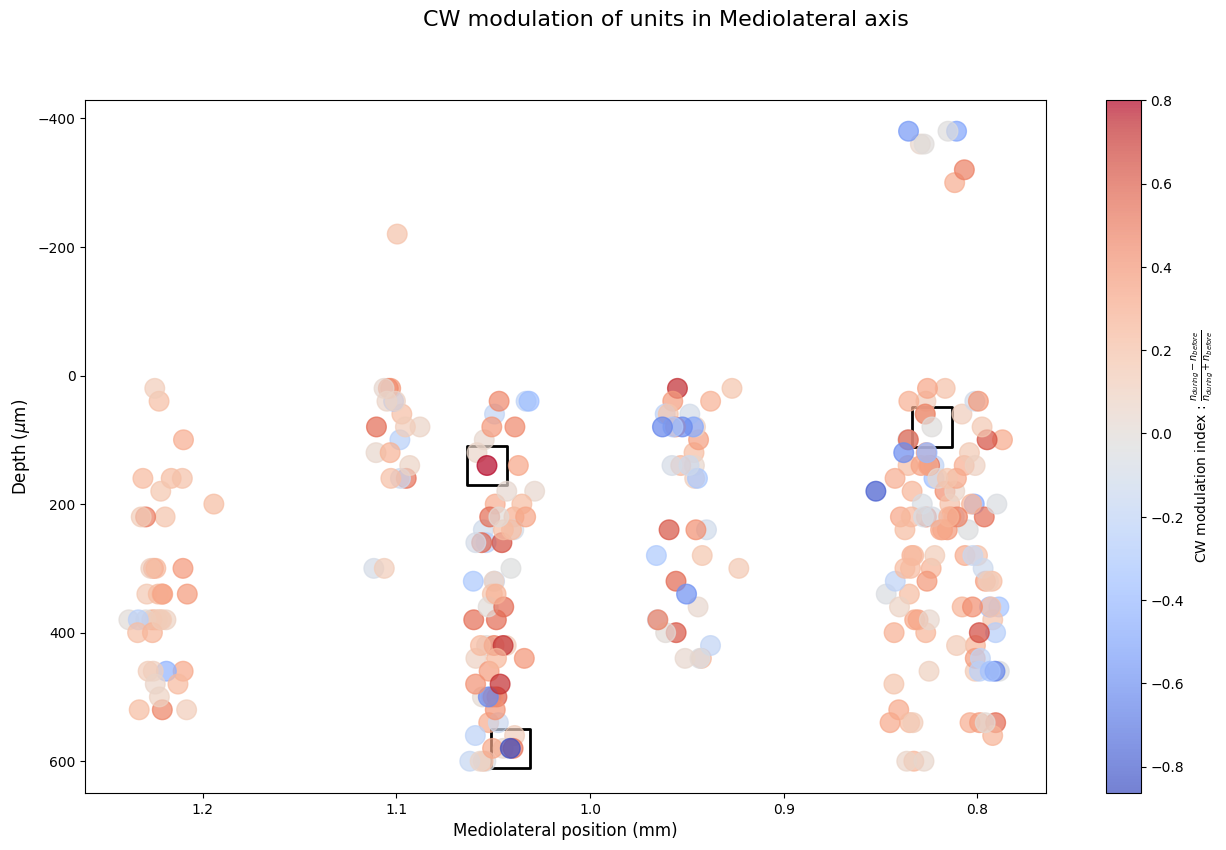

+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+


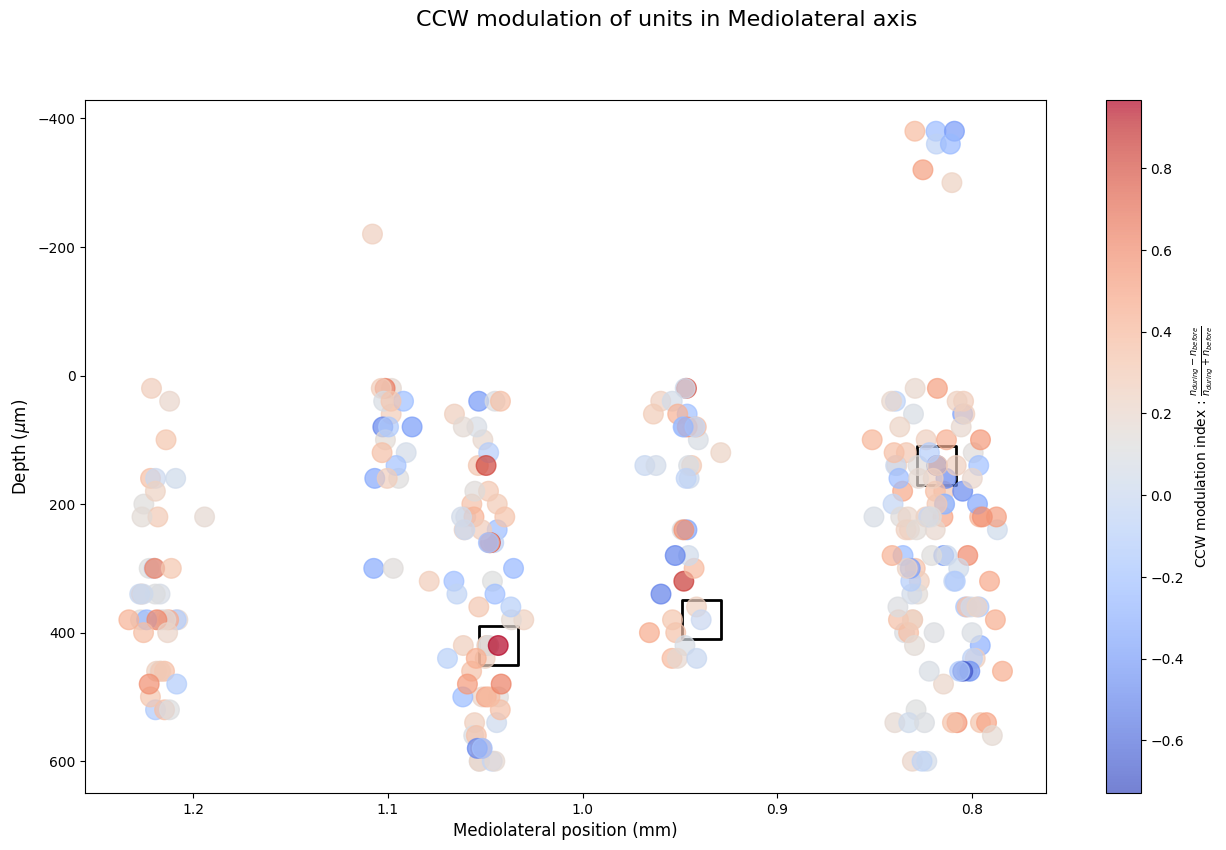

+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+


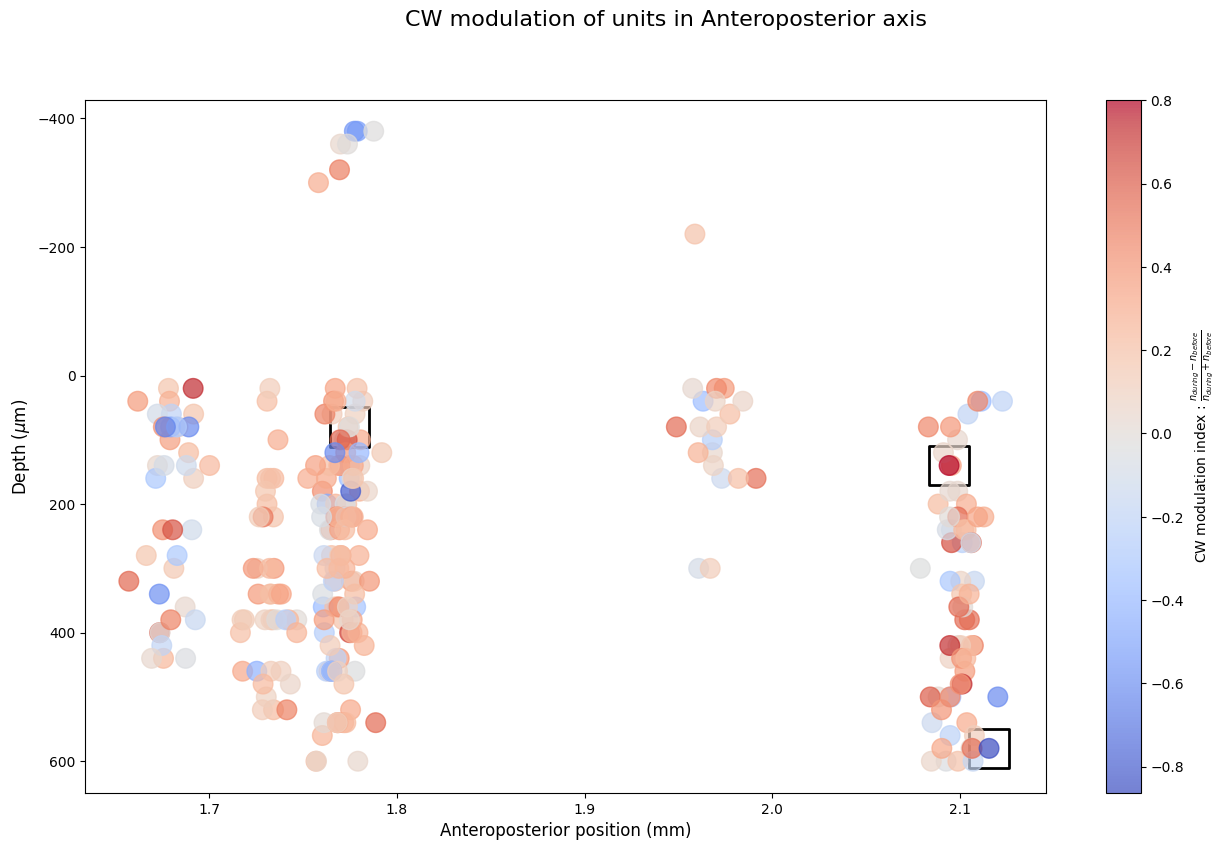

+------------------+-----------------+
|      Animal      | Anteroposterior |
+------------------+-----------------+
| animal21_a17d1s1 |       1.68      |
| animal21_a18d1s1 |       1.73      |
| animal21_a15d1s1 |       1.77      |
| animal21_a21d1s1 |       1.77      |
| animal21_a53d1s1 |       1.77      |
| animal21_a51d1s1 |       1.97      |
| animal21_a19d1s1 |       2.1       |
+------------------+-----------------+


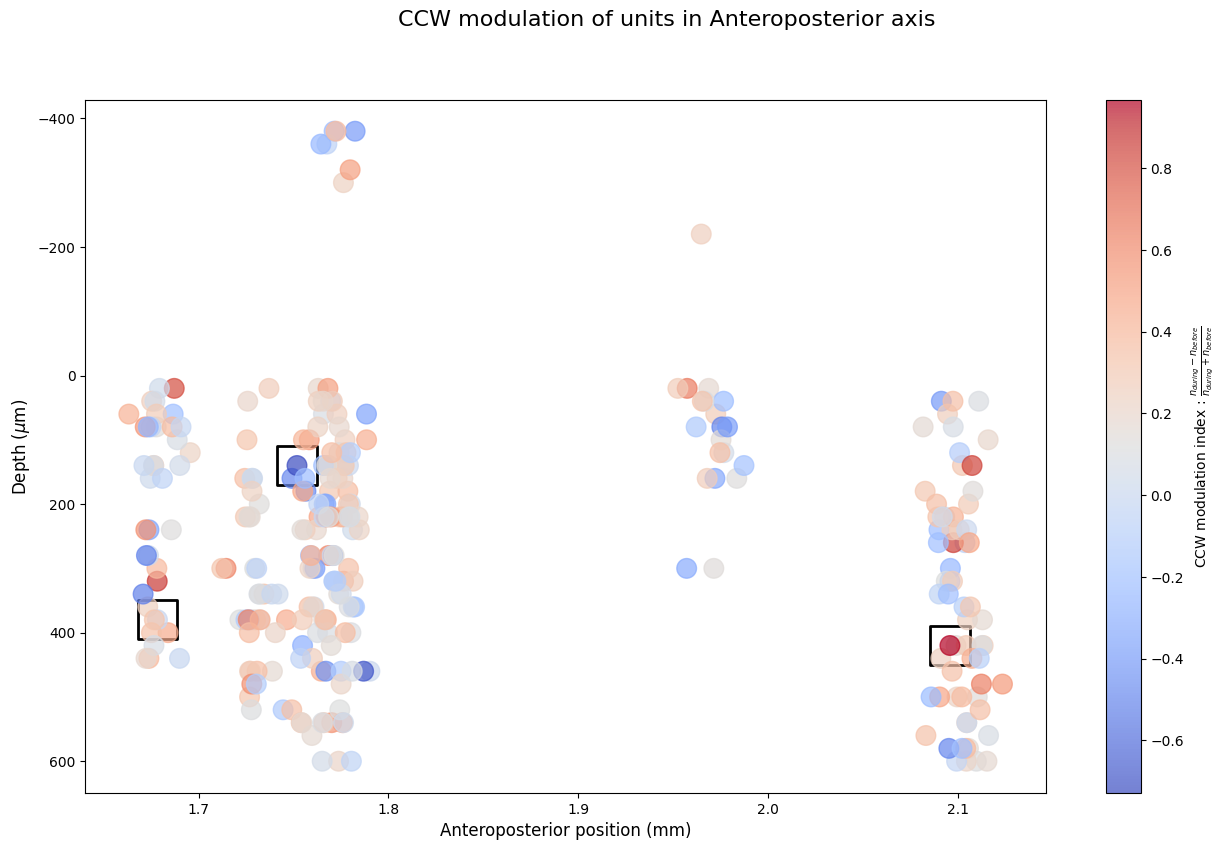

+------------------+-----------------+
|      Animal      | Anteroposterior |
+------------------+-----------------+
| animal21_a17d1s1 |       1.68      |
| animal21_a18d1s1 |       1.73      |
| animal21_a15d1s1 |       1.77      |
| animal21_a21d1s1 |       1.77      |
| animal21_a53d1s1 |       1.77      |
| animal21_a51d1s1 |       1.97      |
| animal21_a19d1s1 |       2.1       |
+------------------+-----------------+


In [12]:
# MODULATION DES UNITS PAR LES MOUVEMENTS DE LA TÊTE
vMI_function(AllData, save=False, interest=['max', 'min', 'nul'], s=200, alpha=0.7)

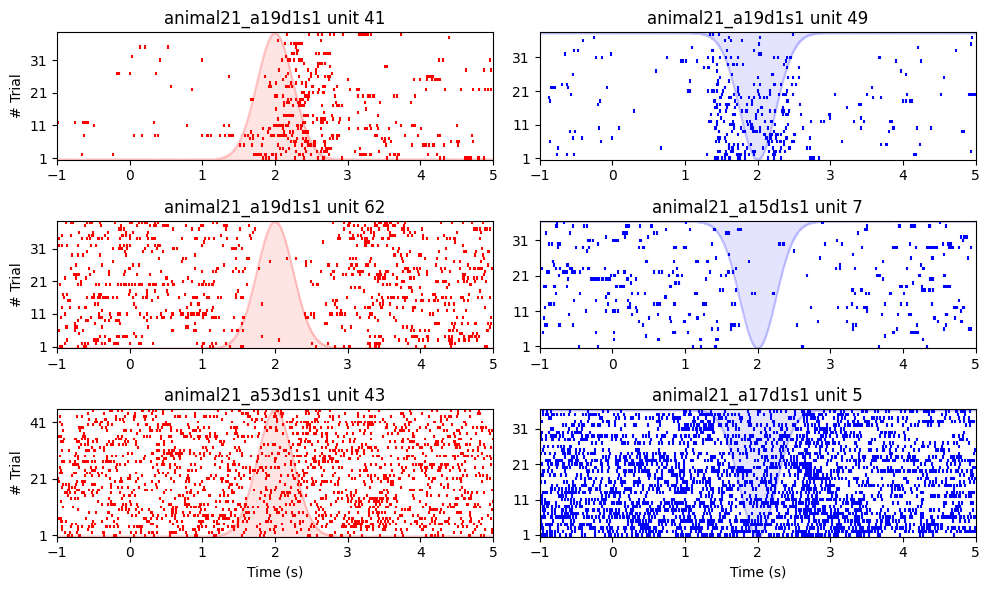

In [11]:
# RASTER DES UNITS PARTICULIERS
plt.figure(figsize=(10, 6))

i = 0

for unit in [max_unit, min_unit, nul_unit]:
    for direction in ['CW', 'CCW']:
        i += 1
        plt.subplot(3, 2, i)
        color = 'red' if direction == 'CW' else 'blue'
        xlabel = '' if i < 5 else 'Time (s)'
        ylabel = '' if i % 2 != 1 else '# Trial'
        title = f"{unit[direction][0]} unit {unit[direction][1]}"
        plotRaster(AllData,unit[direction][0], "second", direction, unit[direction][1], 
                    show=False, 
                    plotvelocity=True, 
                    velocitycolor=color, color=color,
                    title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
plt.show()

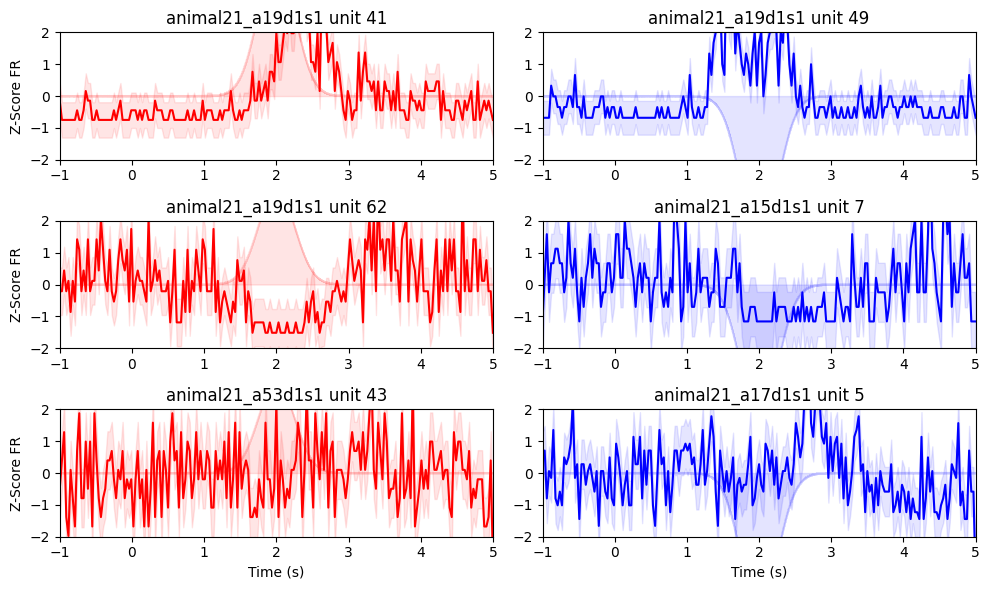

In [12]:
# PSTH DES UNITS PARTICULIERS
plt.figure(figsize=(10, 6))

i = 0

for unit in [max_unit, min_unit, nul_unit]:
    for direction in ['CW', 'CCW']:
        i += 1
        plt.subplot(3, 2, i)
        color = 'red' if direction == 'CW' else 'blue'
        xlabel = '' if i < 5 else 'Time (s)'
        ylabel = '' if i % 2 != 1 else '# Trial'
        plt.ylim(-2,2)
        title = f"{unit[direction][0]} unit {unit[direction][1]}"
        plotPSTH(AllData, unit[direction][0], 'second', direction, unit[direction][1], plotvelocity=True, color=color, shadedcolor=color, velocitycolor=color, show=False, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
plt.show()

Les neurones du Pulvinar sont effectivement modulés par les rotations de la tête.

Comment se distribuent-ils ?

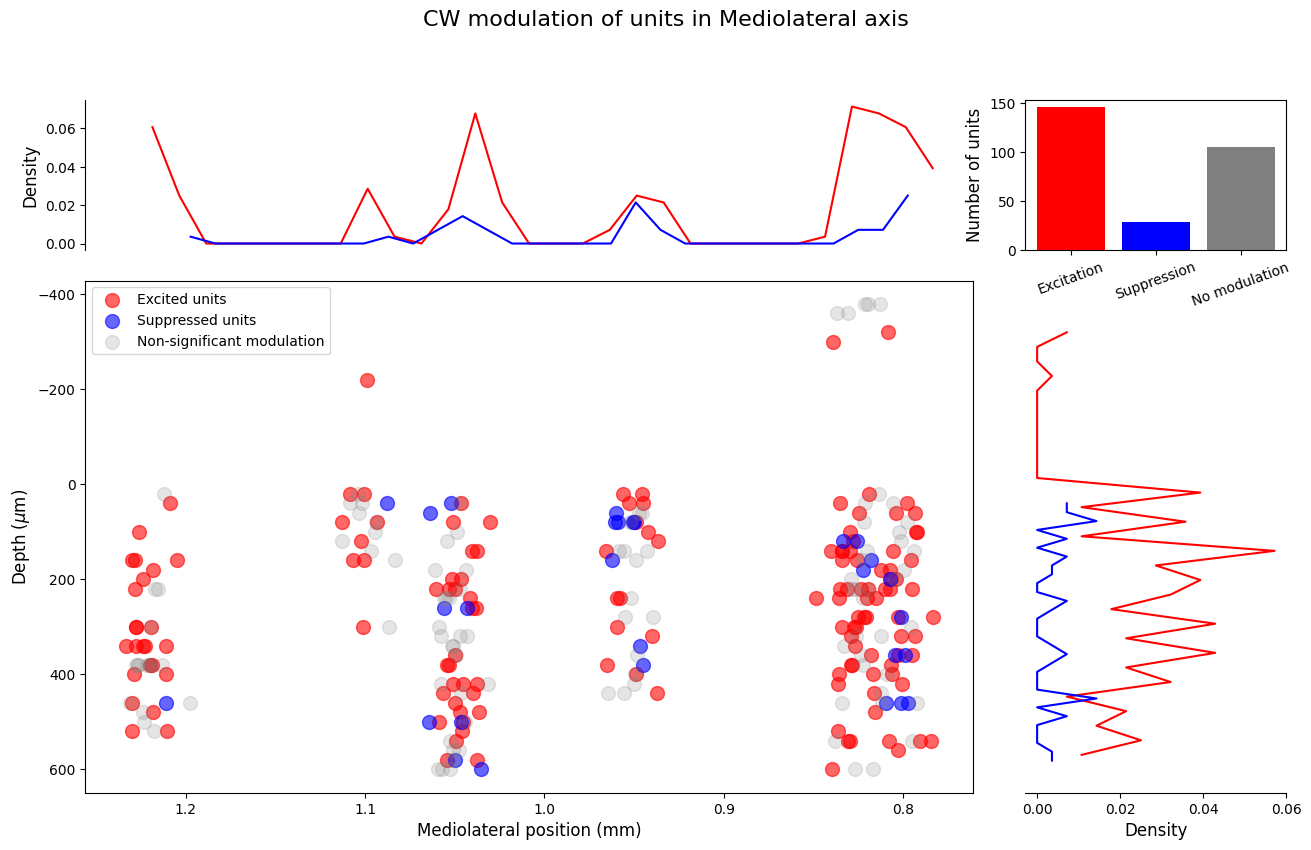

+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+


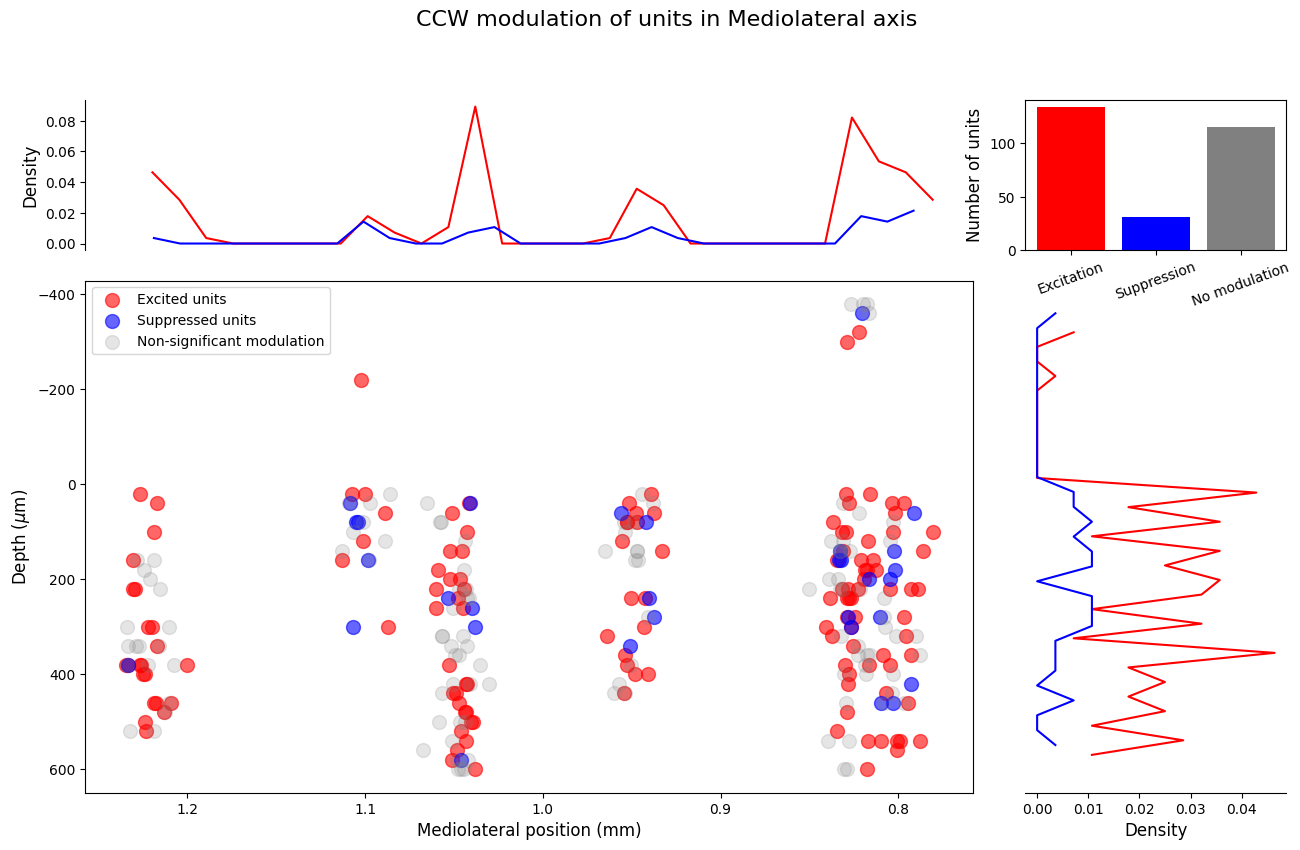

+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+


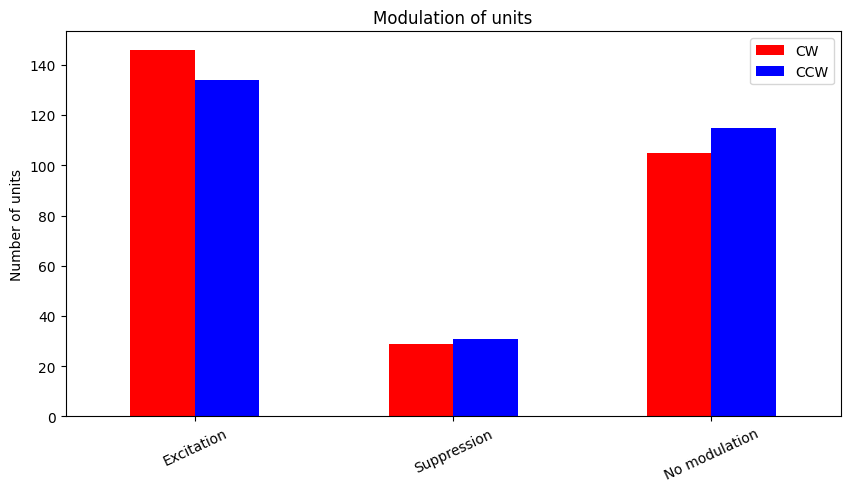

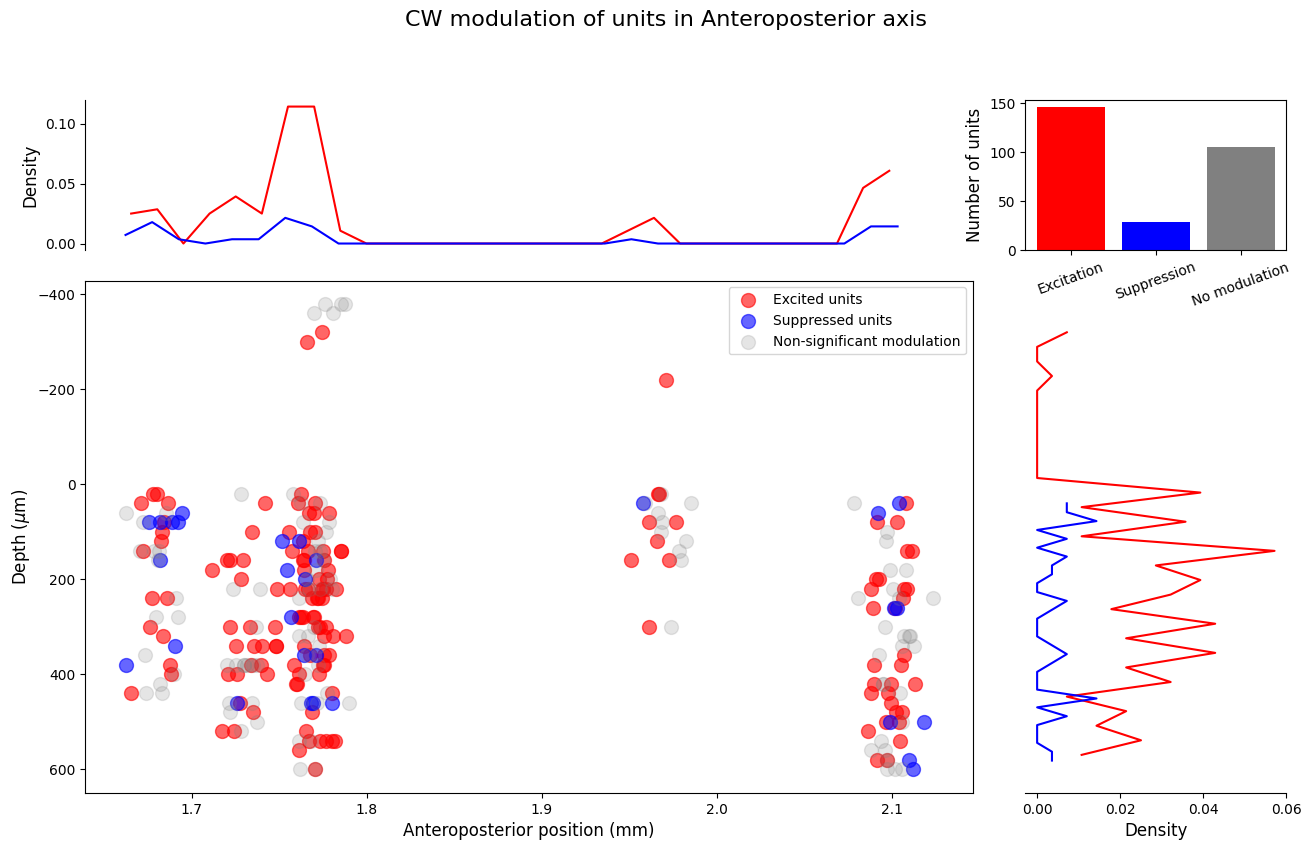

+------------------+-----------------+
|      Animal      | Anteroposterior |
+------------------+-----------------+
| animal21_a17d1s1 |       1.68      |
| animal21_a18d1s1 |       1.73      |
| animal21_a15d1s1 |       1.77      |
| animal21_a21d1s1 |       1.77      |
| animal21_a53d1s1 |       1.77      |
| animal21_a51d1s1 |       1.97      |
| animal21_a19d1s1 |       2.1       |
+------------------+-----------------+


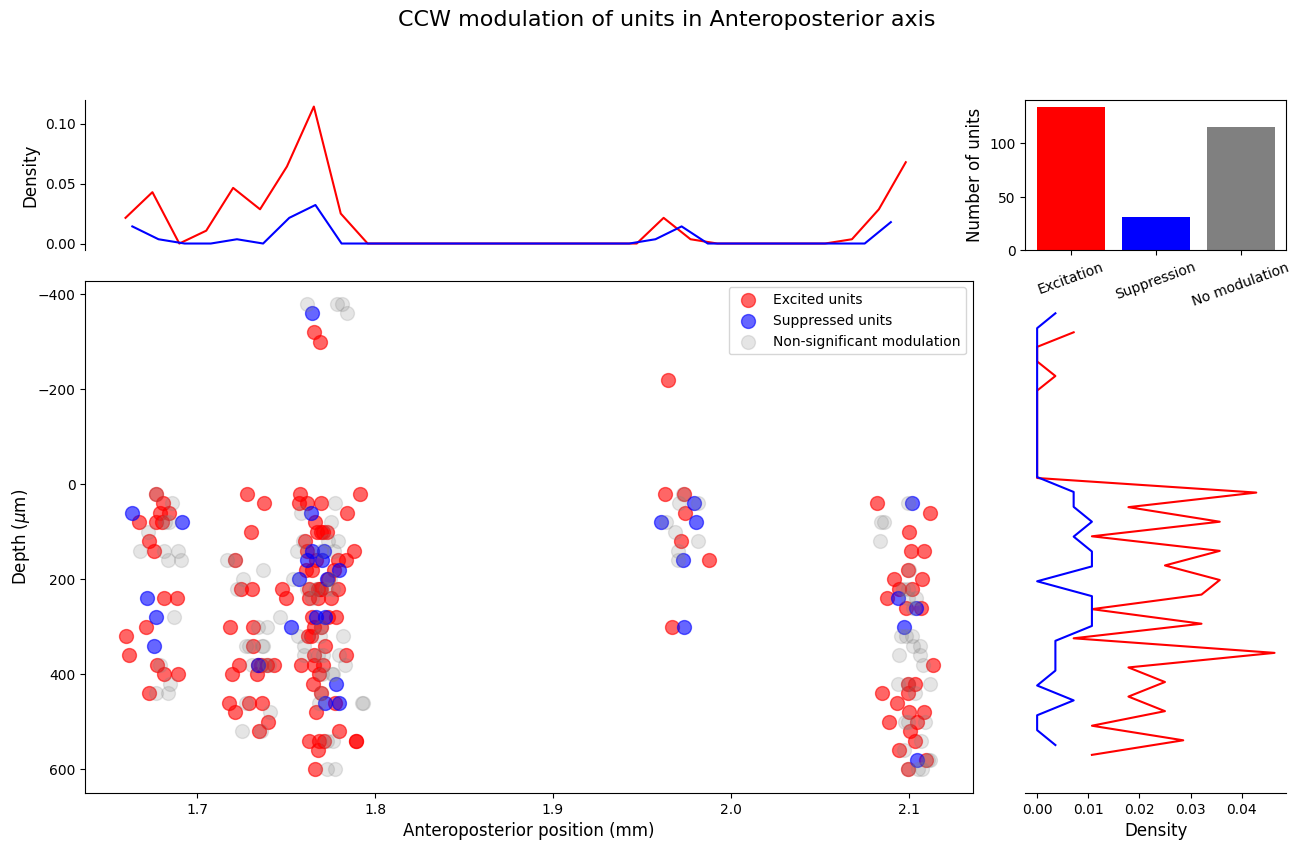

+------------------+-----------------+
|      Animal      | Anteroposterior |
+------------------+-----------------+
| animal21_a17d1s1 |       1.68      |
| animal21_a18d1s1 |       1.73      |
| animal21_a15d1s1 |       1.77      |
| animal21_a21d1s1 |       1.77      |
| animal21_a53d1s1 |       1.77      |
| animal21_a51d1s1 |       1.97      |
| animal21_a19d1s1 |       2.1       |
+------------------+-----------------+


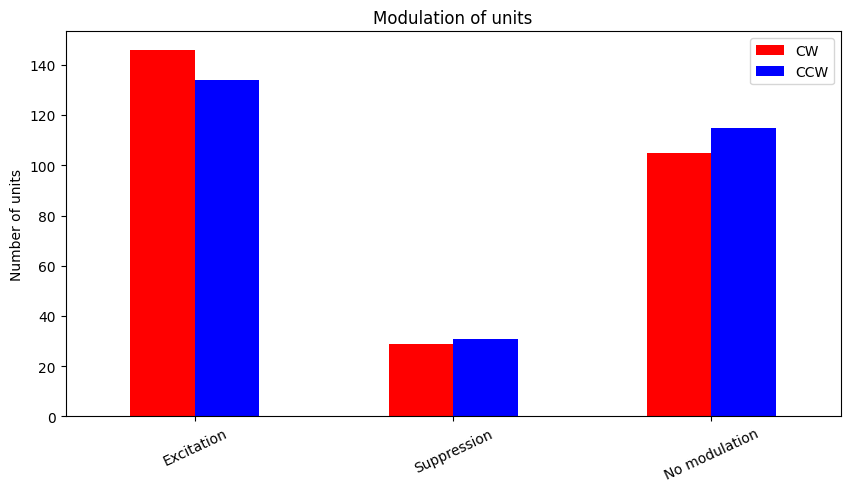

In [13]:
# STATS ON vMI
vMI_function(AllData, stats=True, hist=True)

### dirMI

Nous voyons que la modulation est majoritairement observée pour une rotation CW, dans le pulvinar de l'hémisphère gauche. 

La question suivante est : que préfèrent les neurones, lorsqu'une modulation existe ?

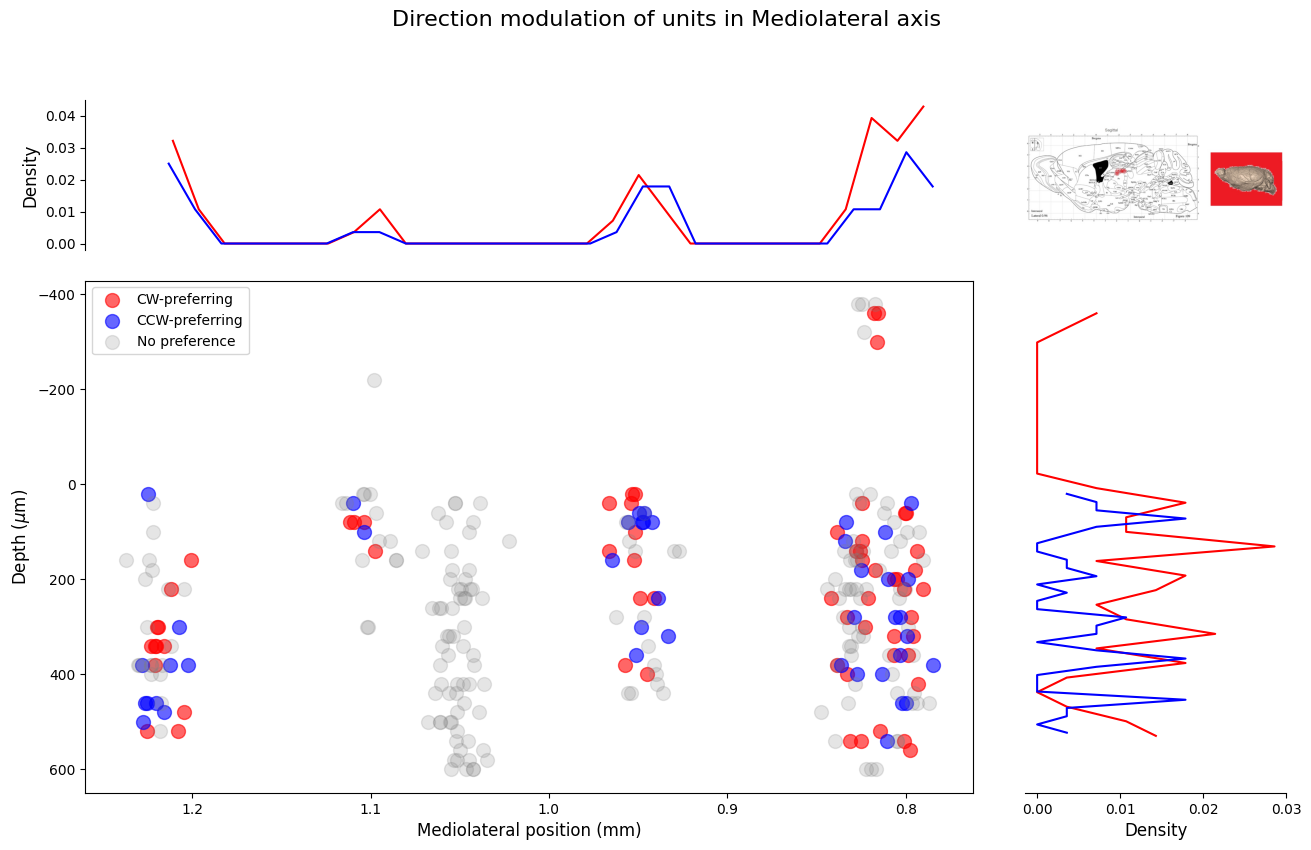

+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+


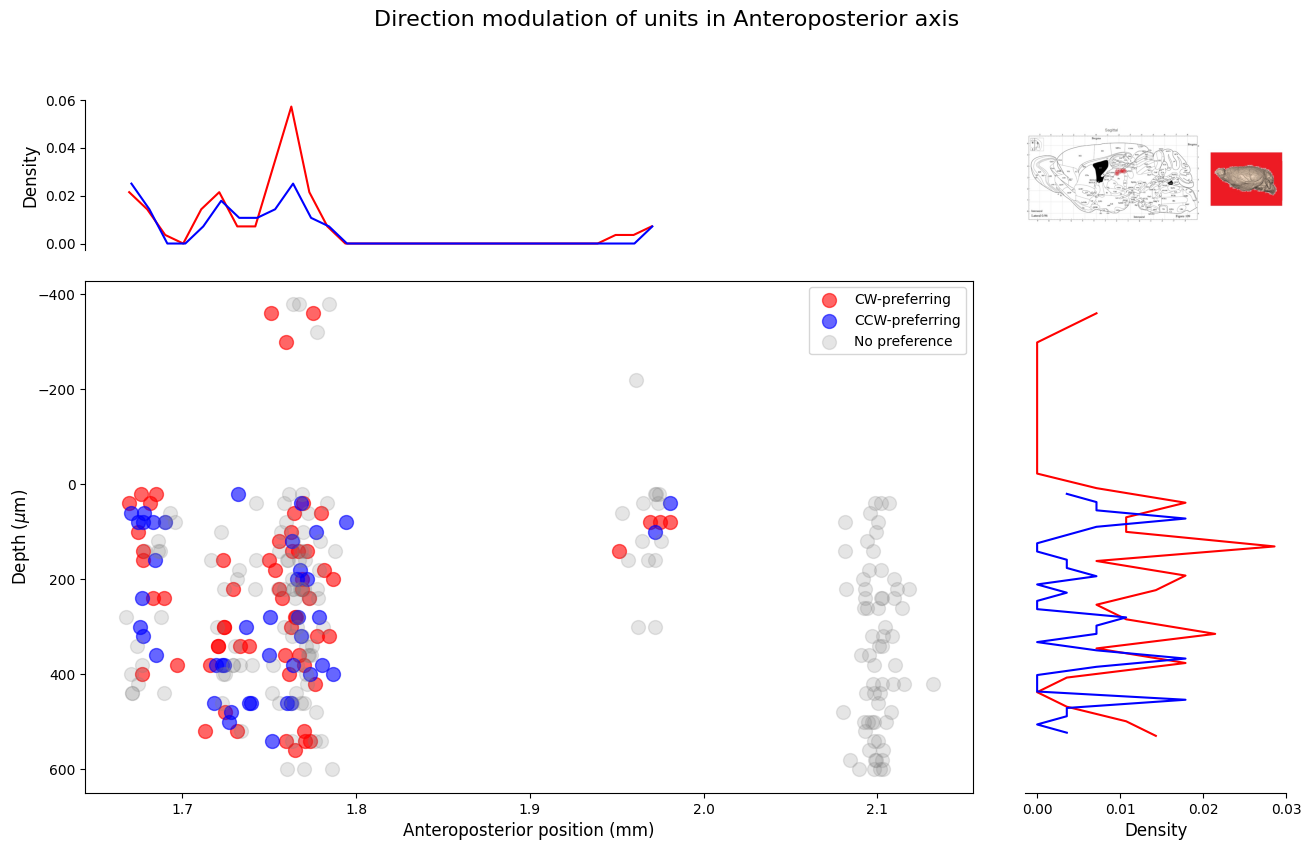

+------------------+-----------------+
|      Animal      | Anteroposterior |
+------------------+-----------------+
| animal21_a17d1s1 |       1.68      |
| animal21_a18d1s1 |       1.73      |
| animal21_a15d1s1 |       1.77      |
| animal21_a21d1s1 |       1.77      |
| animal21_a53d1s1 |       1.77      |
| animal21_a51d1s1 |       1.97      |
| animal21_a19d1s1 |       2.1       |
+------------------+-----------------+


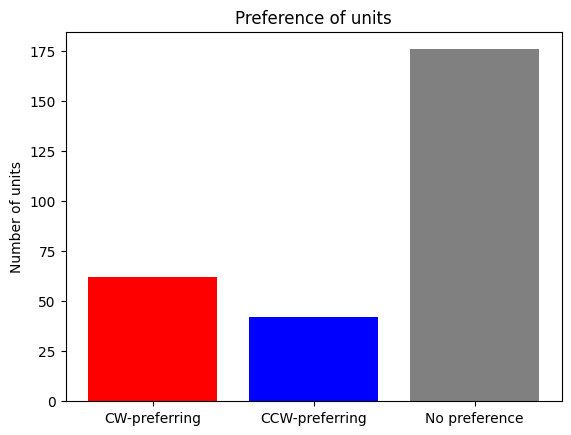

In [14]:
# DIRECTION PREFERENCE
dirMI_function(AllData, stats=True, hist=True)

animal21_a15d1s1
[]
animal21_a17d1s1
[ 0  1  2 23]


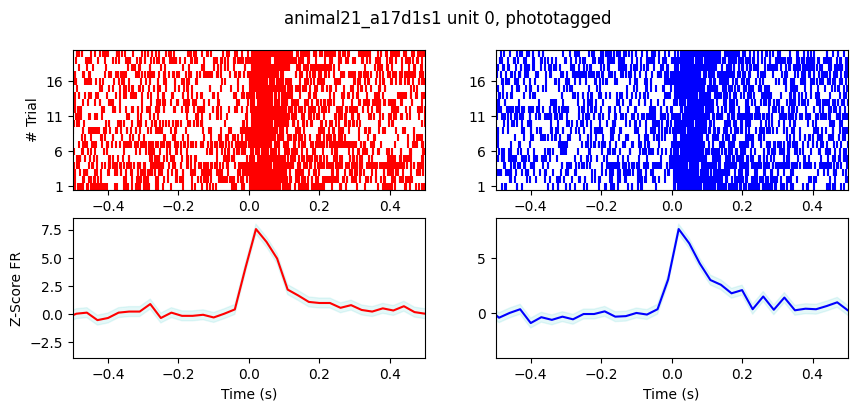

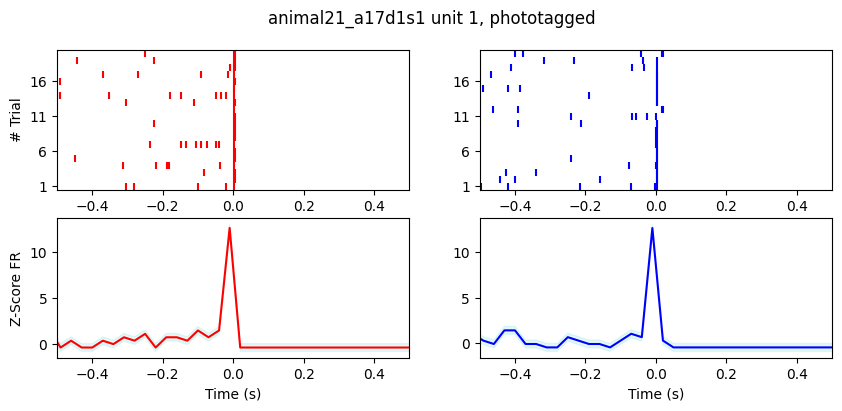

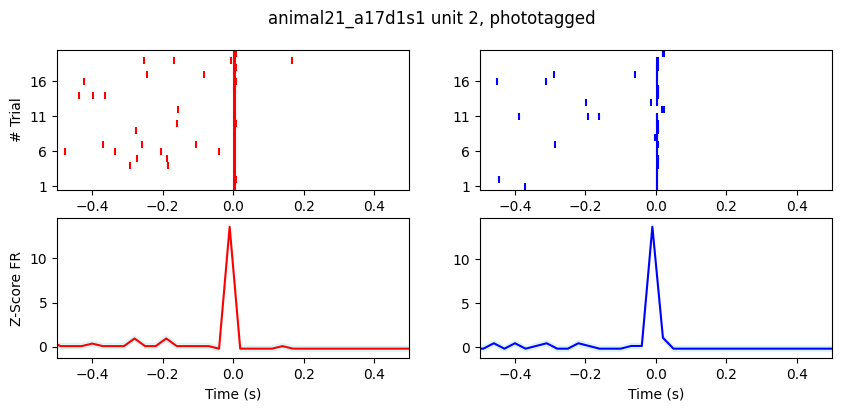

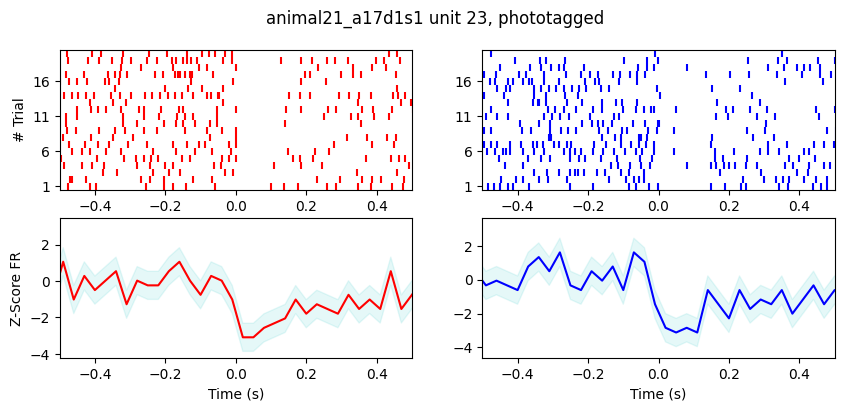

animal21_a18d1s1
[9]


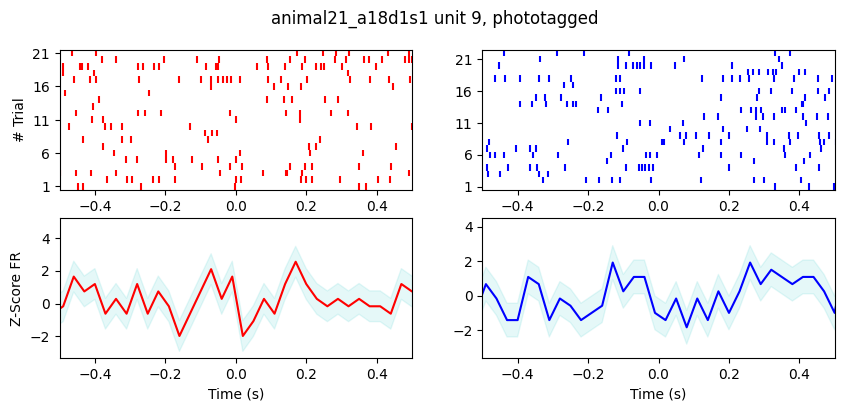

animal21_a19d1s1
[]
animal21_a21d1s1
[]
animal21_a51d1s1
[]
animal21_a53d1s1
[ 0 19 23 35 40 45]


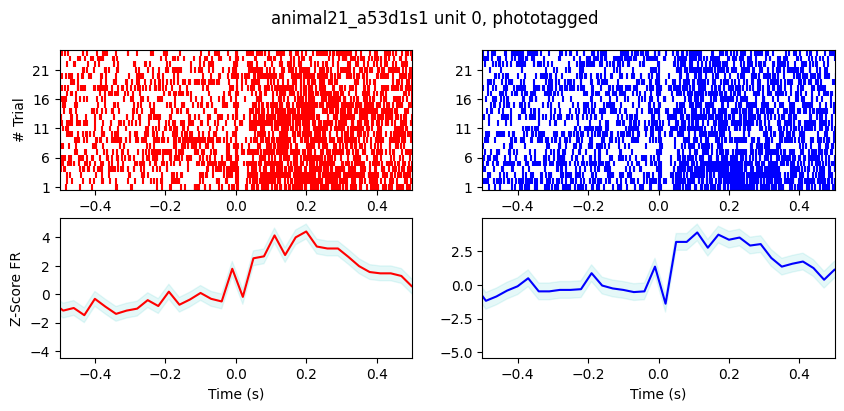

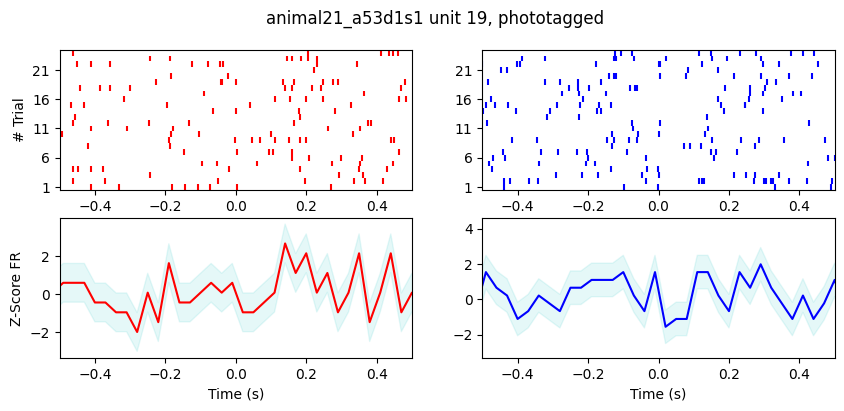

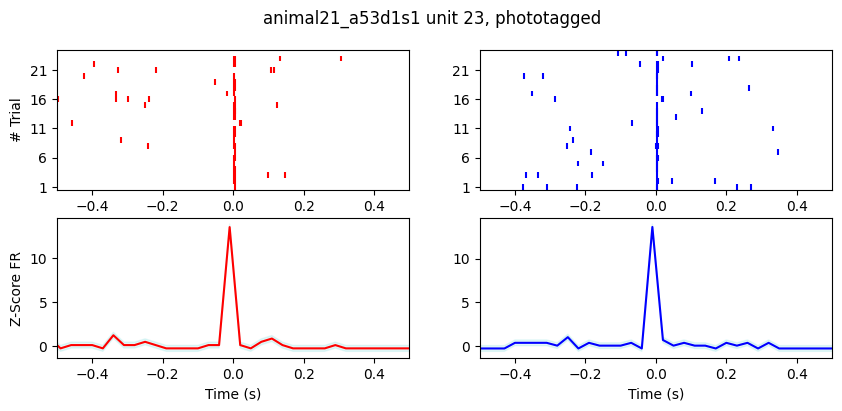

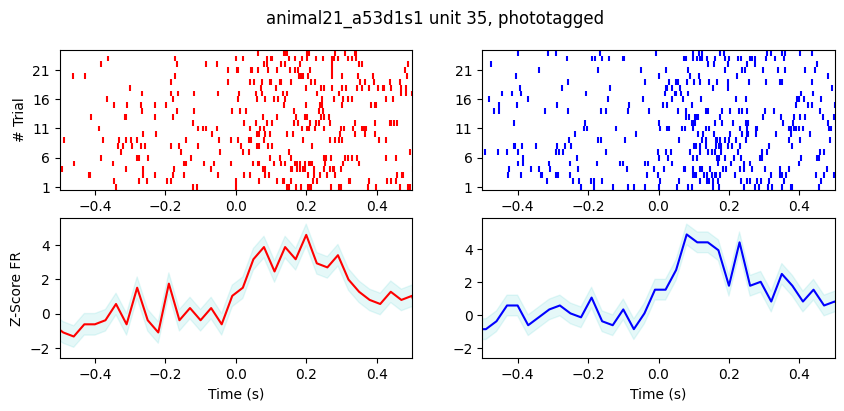

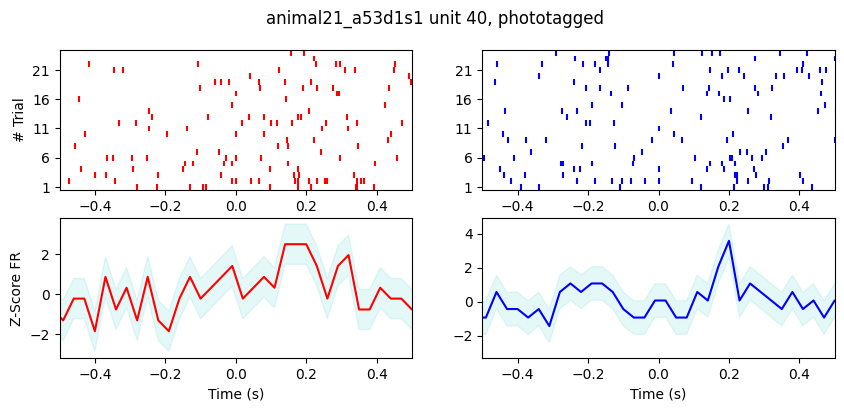

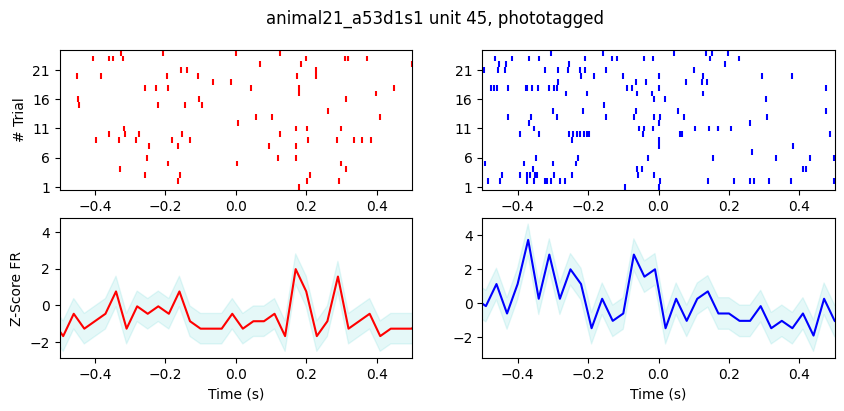

In [46]:
for animal in AllData:
    print(animal)
    phototagged_units= np.where(modulation[animal]['first']==1)[0]
    print(phototagged_units)
    for unit in phototagged_units:
        plt.figure(figsize=(10,4))
        plt.subplot(221)
        plotRaster(AllData, animal, "first", "CW", unit, color='red', show=False, xlim=(-0.5,0.5))
        plt.subplot(222)
        plotRaster(AllData, animal, "first", "CCW", unit, color='blue', show=False, ylabel=False, xlim=(-0.5,0.5))
        plt.subplot(223)
        plotPSTH(AllData, animal, "first", "CW", unit, color='red', show=False, xlim=(-0.5,0.5))
        plt.subplot(224)
        plotPSTH(AllData, animal, "first", "CCW", unit, color='blue', show=False, ylabel=False, xlim=(-0.5,0.5))
        plt.suptitle(f"{animal} unit {unit}, phototagged")
        plt.show()

animal21_a15d1s1
[]
animal21_a17d1s1
[ 0  1  2 23]


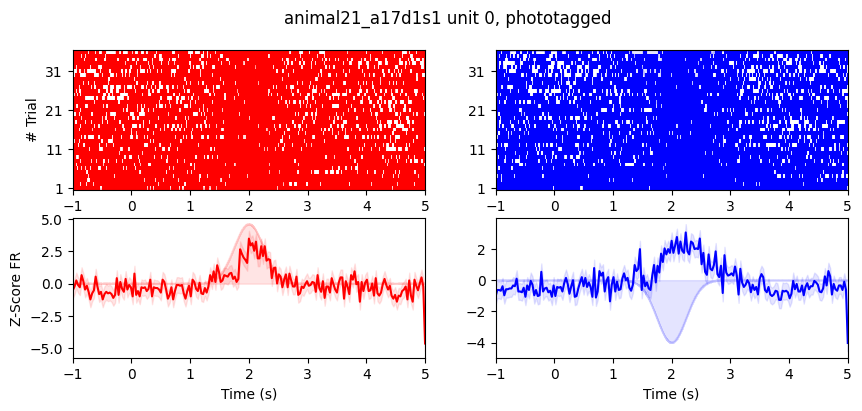

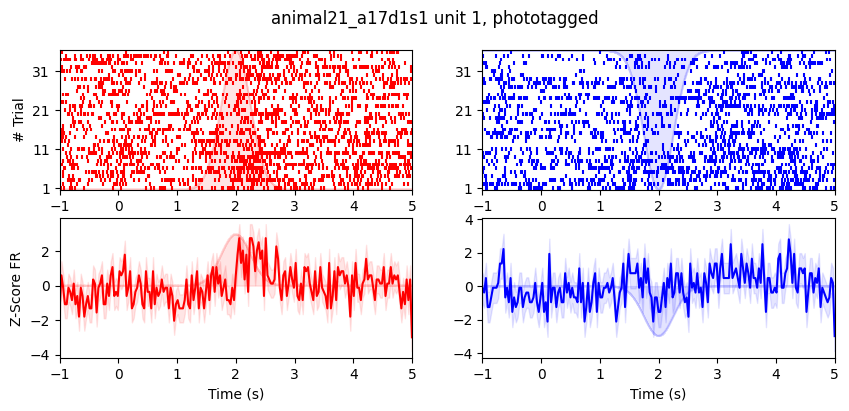

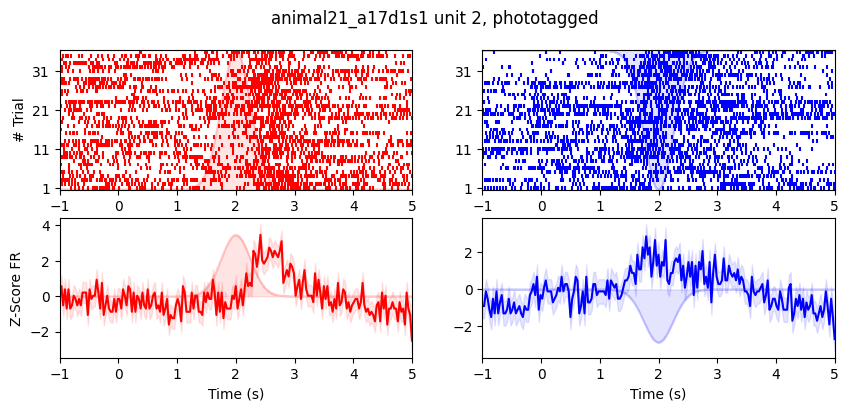

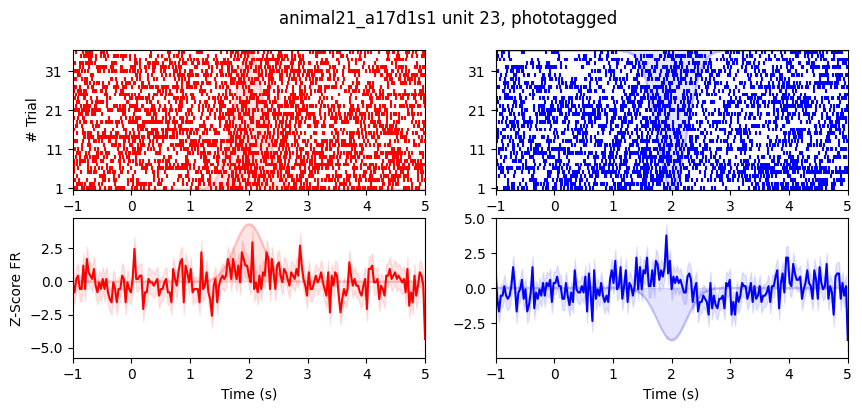

animal21_a18d1s1
[9]


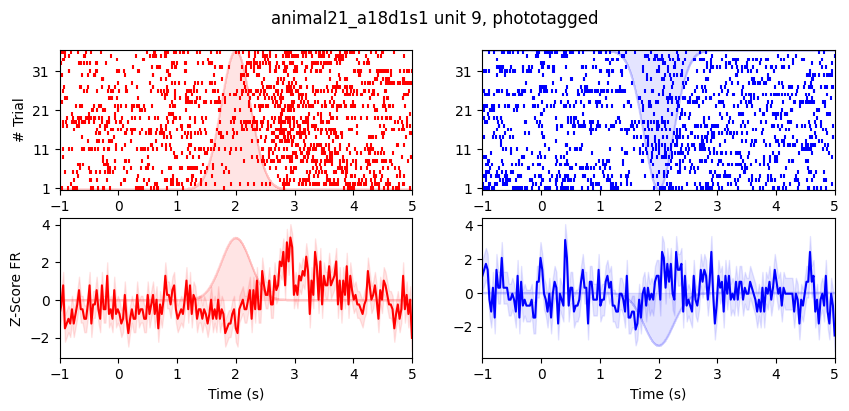

animal21_a19d1s1
[]
animal21_a21d1s1
[]
animal21_a51d1s1
[]
animal21_a53d1s1
[ 0 19 23 35 40 45]


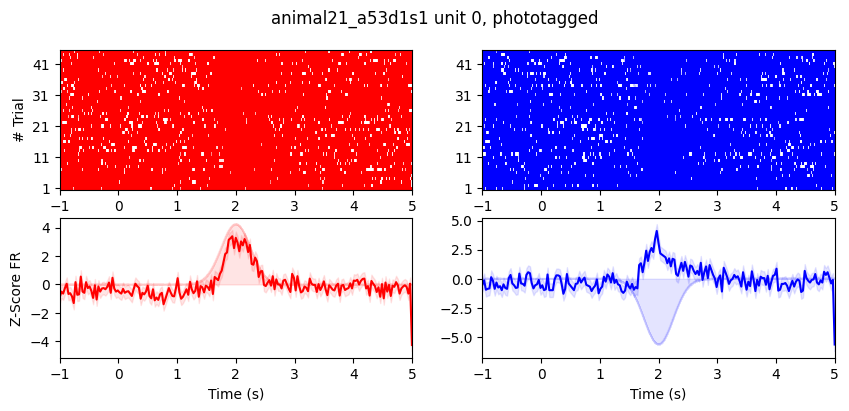

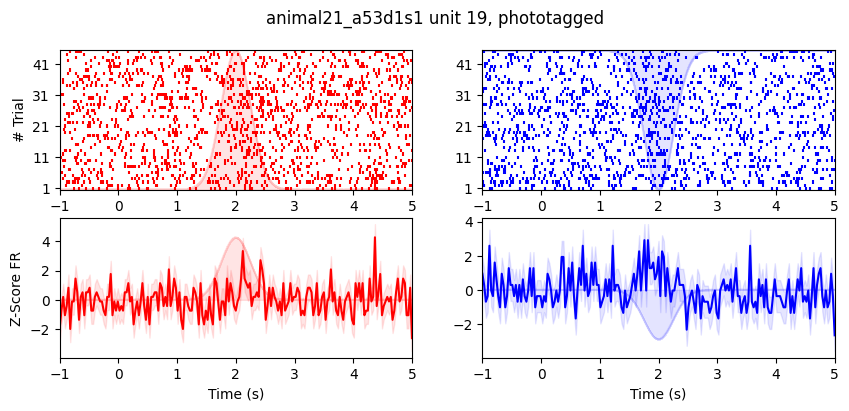

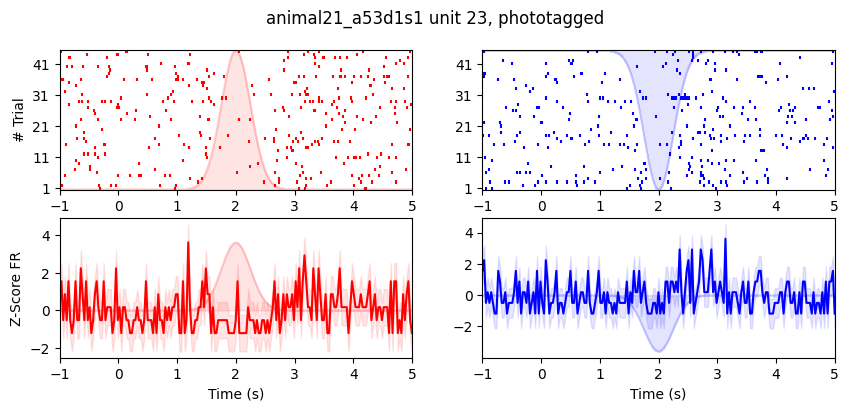

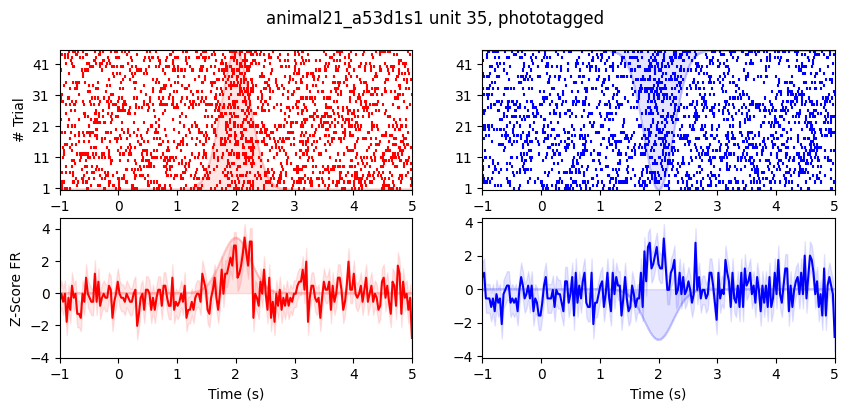

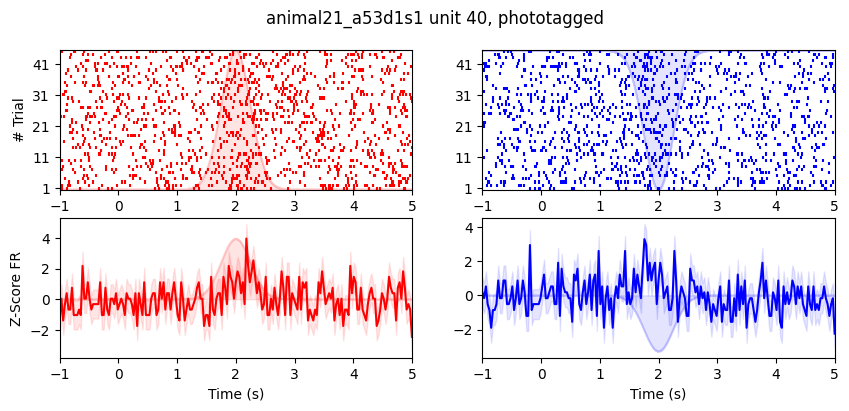

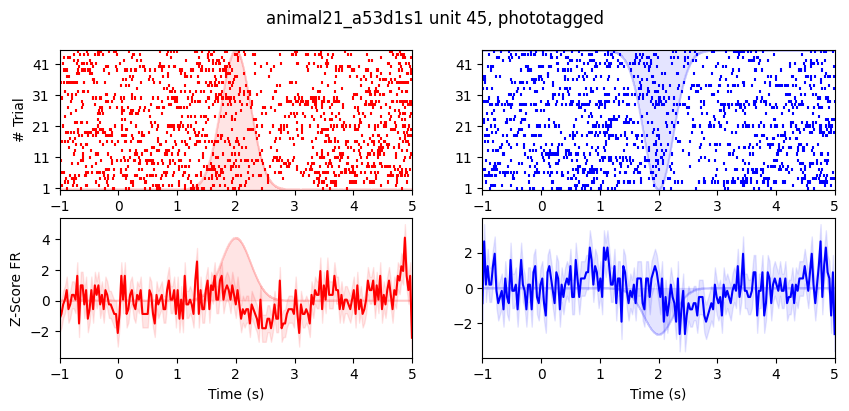

In [53]:
for animal in AllData:
    print(animal)
    phototagged_units = np.where(modulation[animal]['first']==1)[0]
    print(phototagged_units)
    for unit in phototagged_units:
        plt.figure(figsize=(10,4))
        plt.subplot(221)
        plotRaster(AllData, animal, "second", "CW", unit, plotvelocity=True, velocitycolor='red', color='red', show=False)
        plt.subplot(222)
        plotRaster(AllData, animal, "second", "CCW", unit, plotvelocity=True, velocitycolor='blue', color='blue', show=False, ylabel=False)
        plt.subplot(223)
        plotPSTH(AllData, animal, "second", "CW", unit, plotvelocity=True, velocitycolor='red', shadedcolor='red', color='red', show=False)
        plt.subplot(224)
        plotPSTH(AllData, animal, "second", "CCW", unit, plotvelocity=True, velocitycolor='blue', color='blue', shadedcolor='blue', show=False, ylabel=False)
        plt.suptitle(f"{animal} unit {unit}, phototagged")
        plt.show()

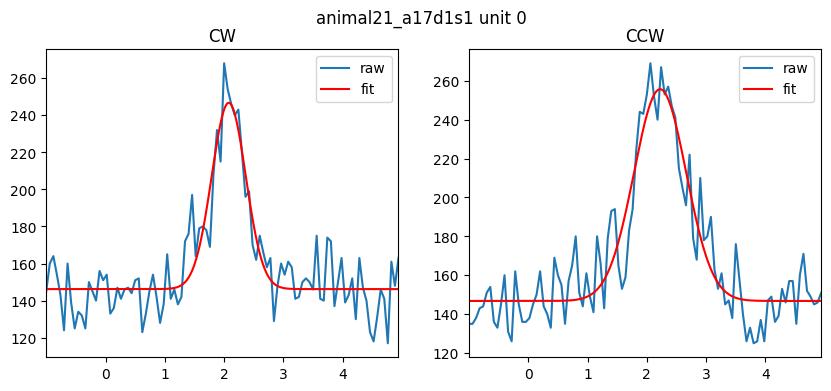

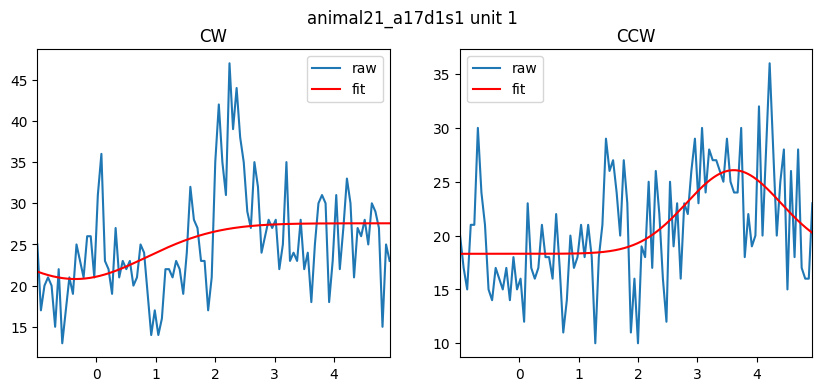

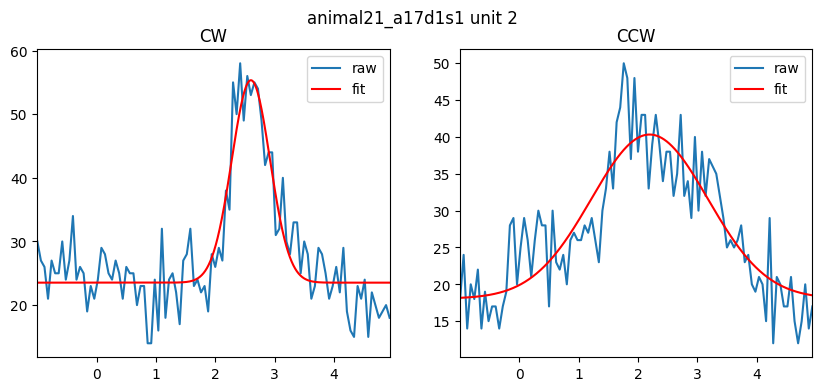

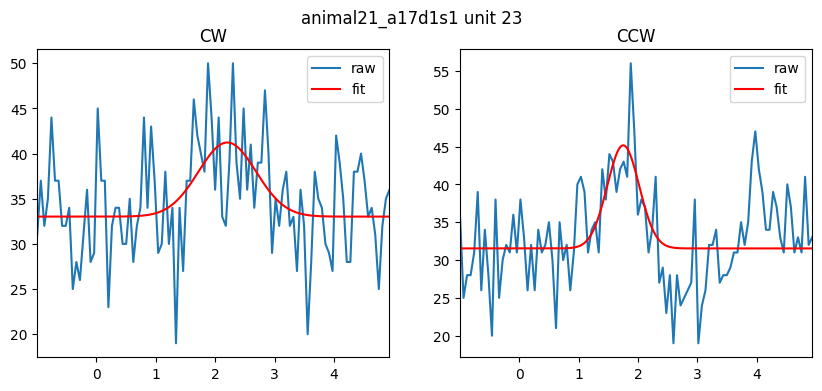

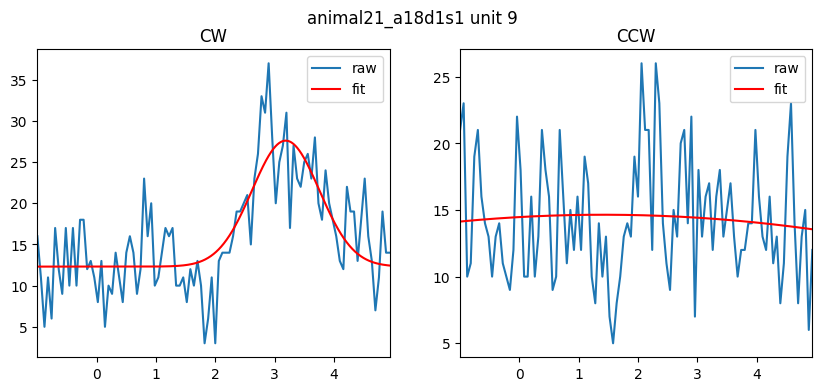

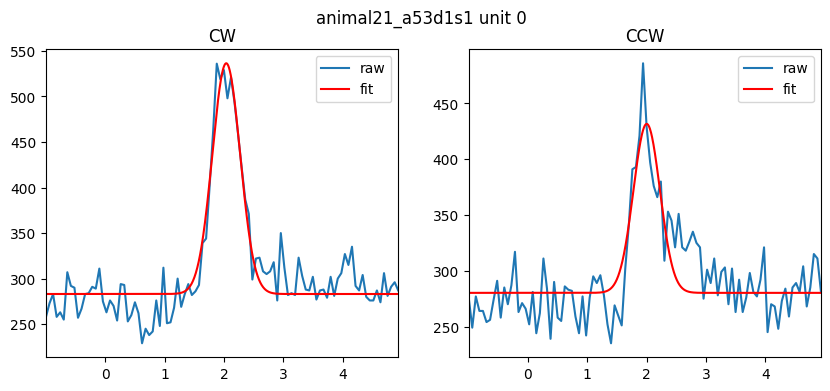

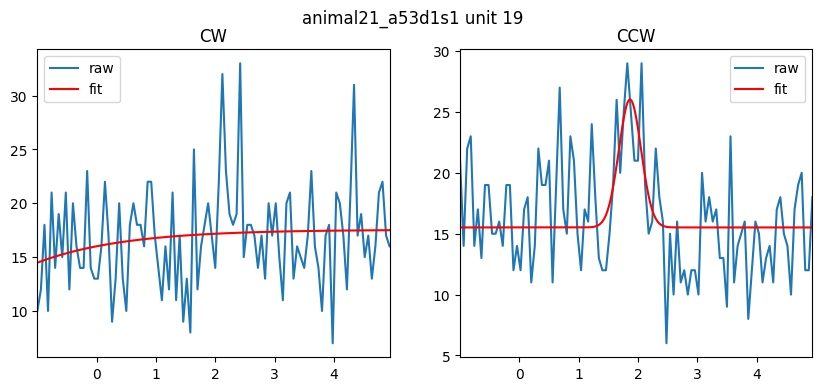

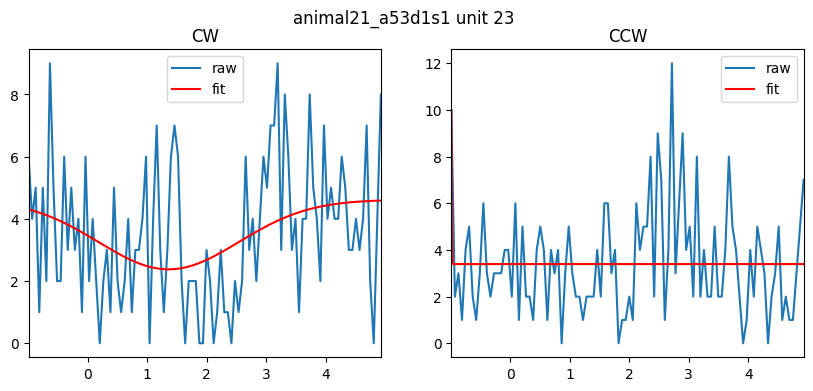

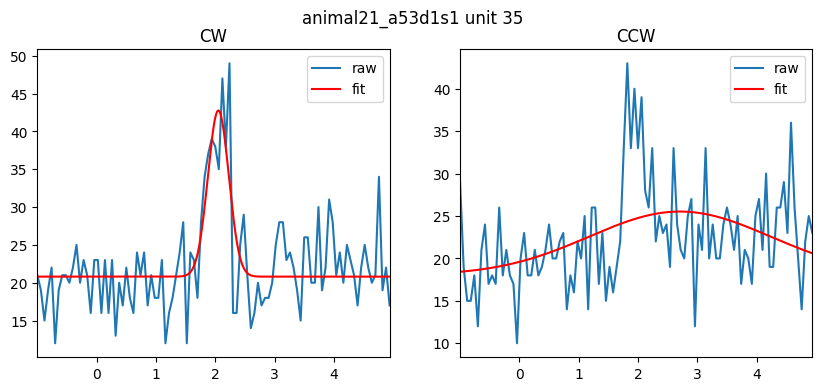

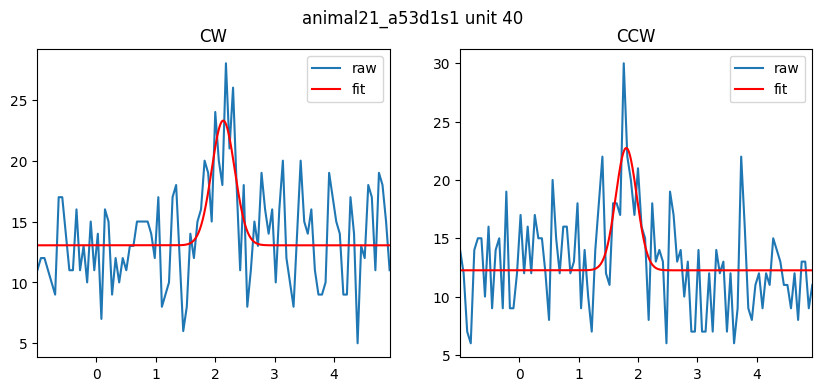

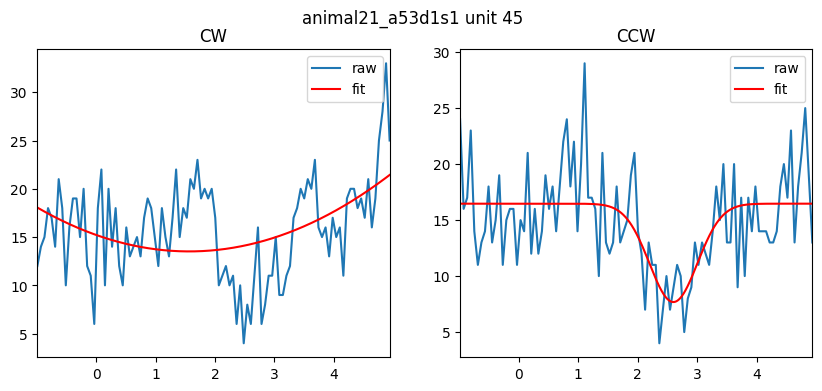

In [223]:
from scipy.optimize import curve_fit

def Gauss(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset





for animal in AllData:
    phototagged_units = np.where(modulation[animal]['first']==1)[0]
    for unit in phototagged_units:
        yCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CW'][unit]]), 100)
        yCCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CCW'][unit]]), 100)
        
        x = edges[:-1]
        x_fit = np.linspace(np.min(x), np.max(x), 1000)

        poptCW, _ = curve_fit(Gauss, x, yCW, p0=[np.max(yCW), np.median(x), np.std(x), np.min(yCW)], maxfev=20000)
        poptCCW, _ = curve_fit(Gauss, x, yCCW, p0=[np.max(yCCW), np.median(x), np.std(x), np.min(yCCW)], maxfev=20000)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.plot(x, yCW, label='raw')
        plt.plot(x_fit, Gauss(x_fit, *poptCW), 'r-', label='fit')
        plt.legend()
        plt.title('CW')
        plt.margins(0,0.05)
        plt.subplot(122)
        plt.plot(x, yCCW, label='raw')
        plt.plot(x_fit, Gauss(x_fit, *poptCCW), 'r-', label='fit')
        plt.legend()
        plt.title('CCW')
        plt.margins(0,0.05)
        plt.suptitle(f"{animal} unit {unit}")
        plt.show()

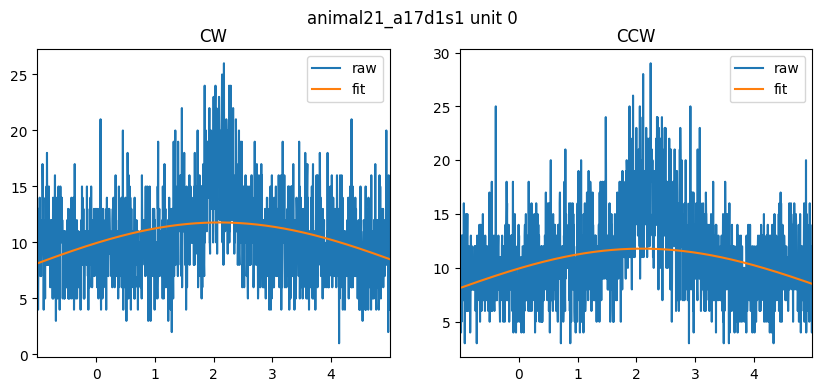

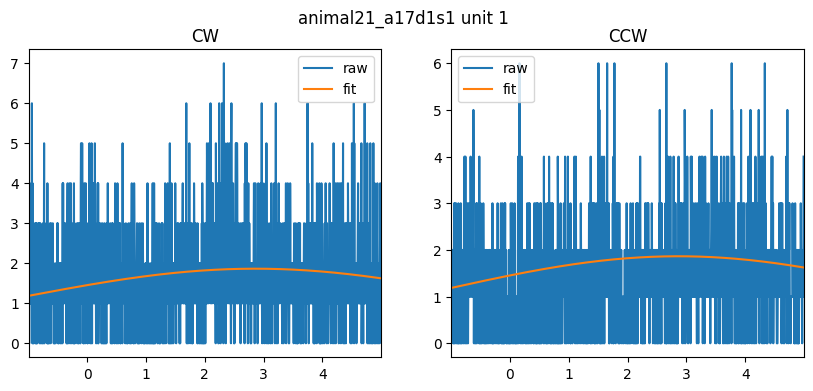

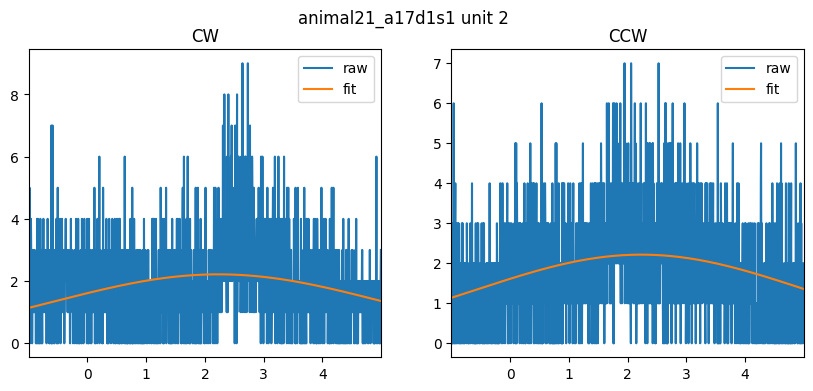

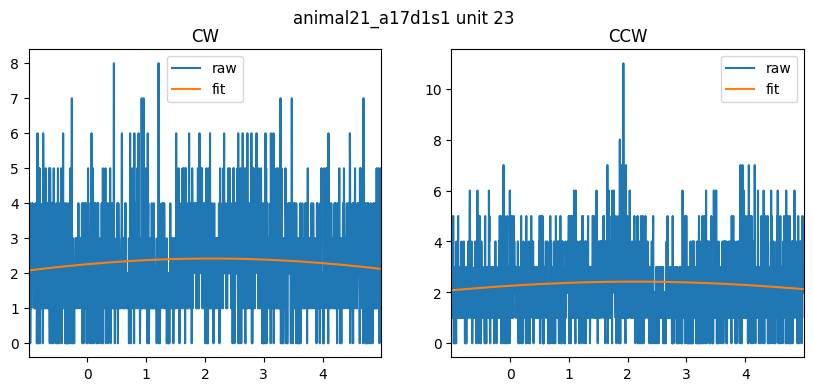

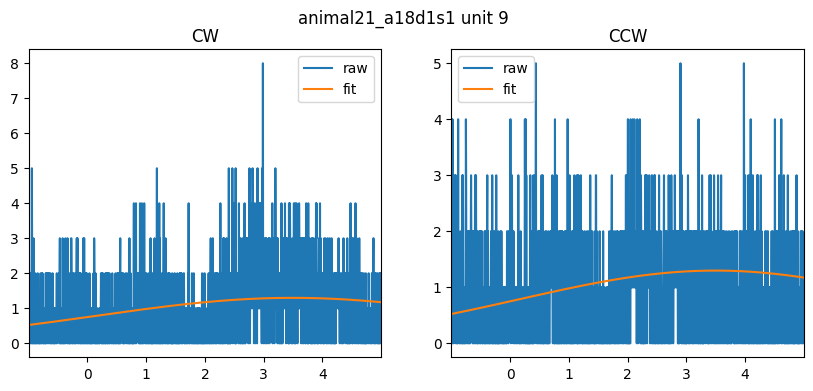

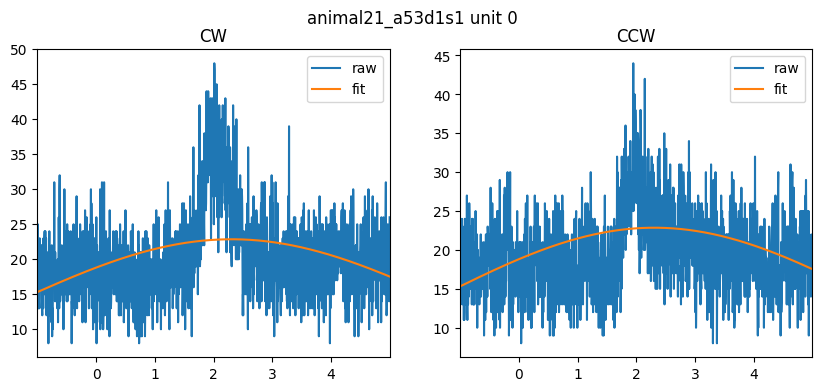

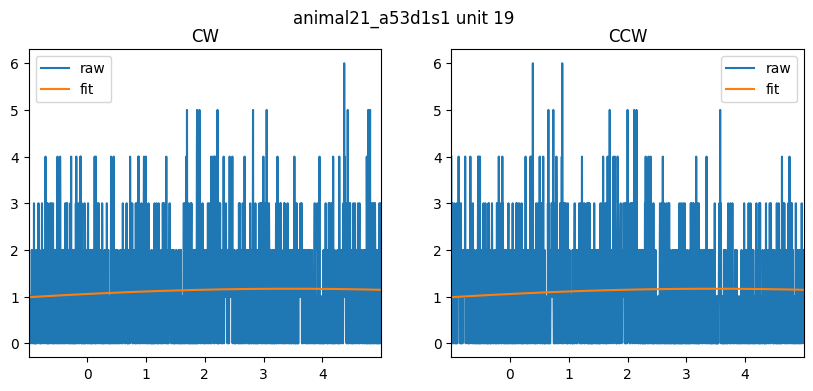

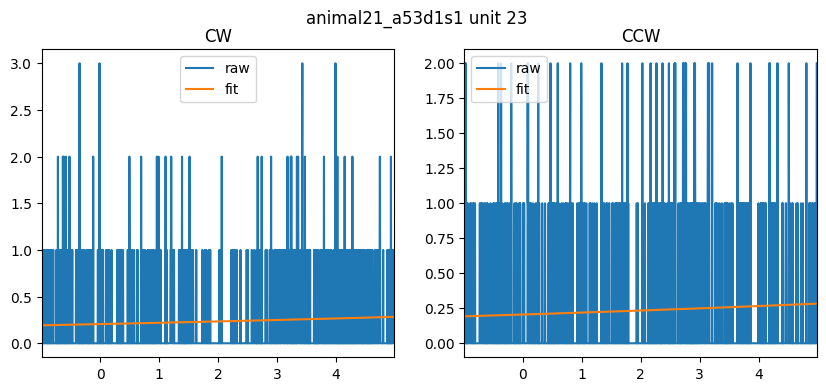

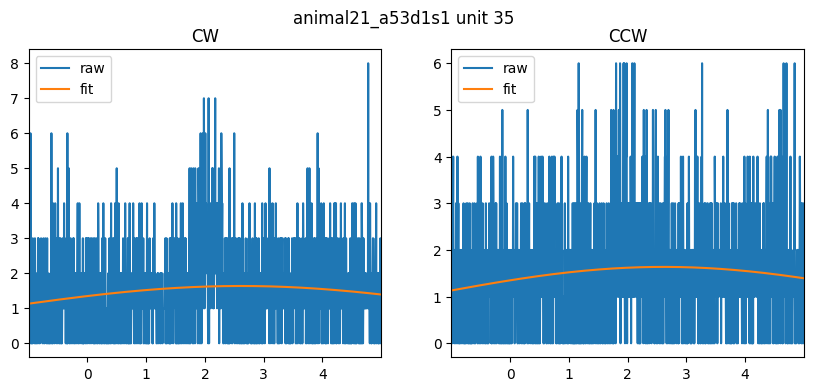

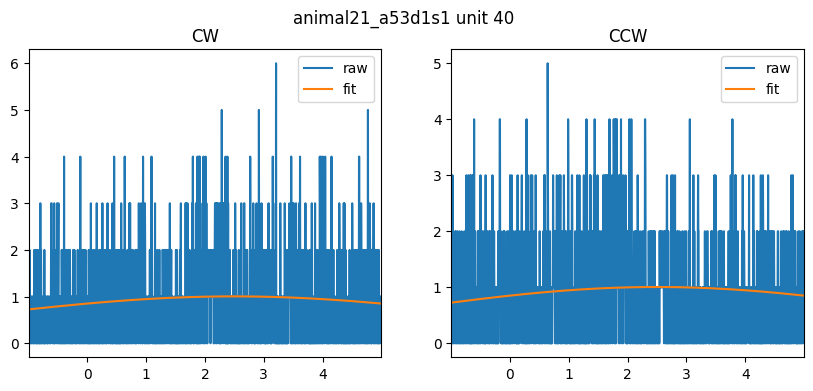

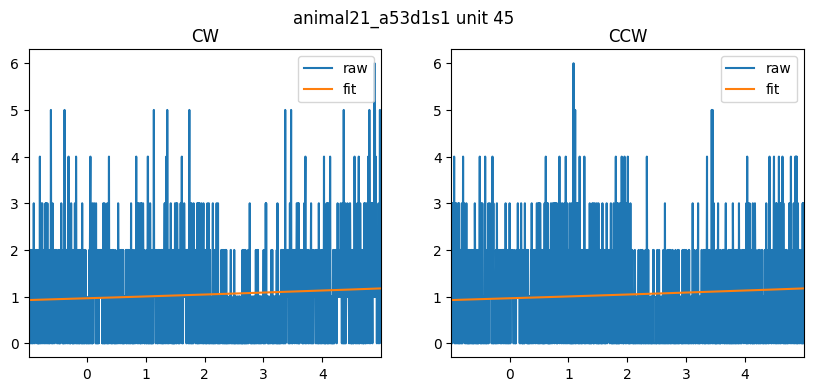

In [180]:
import pylab as plb
import matplotlib.pyplot as plt
from astropy import modeling

for animal in AllData:
    phototagged_units = np.where(modulation[animal]['first']==1)[0]
    for unit in phototagged_units:
        yCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CW'][unit]]), 1500)
        yCCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CCW'][unit]]), 1500)
        x = edges[:-1]

        fitter = modeling.fitting.LevMarLSQFitter()
        model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
        fitted_model = fitter(model, x, yCW)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.plot(x, yCW, label='raw')
        plt.plot(x, fitted_model(x), label='fit')
        plt.legend()
        plt.title('CW')
        plt.margins(0,0.05)
        plt.subplot(122)
        plt.plot(x, yCCW, label='raw')
        plt.plot(x, fitted_model(x), label='fit')
        plt.legend()
        plt.title('CCW')
        plt.margins(0,0.05)
        plt.suptitle(f"{animal} unit {unit}")
        plt.show()

In [16]:
# # RasterTheme = (
# #     load_theme("arctic_light")
# #         .set_grid(False)
# #         .set_transforms(trim=True)
# # )

# RasterTheme = (
#     Theme(name="demo", description="A demo theme.")
#     .set_grid(draw=True, width=0.5)
#     .set_font(family="monospace")
#     .set_color(grid_color="red")
# )

# RasterTheme = (
#     load_theme("arctic_light")
#         .set_grid(False)
#         .set_transforms(trim=True)
# )

### 3D Scatter

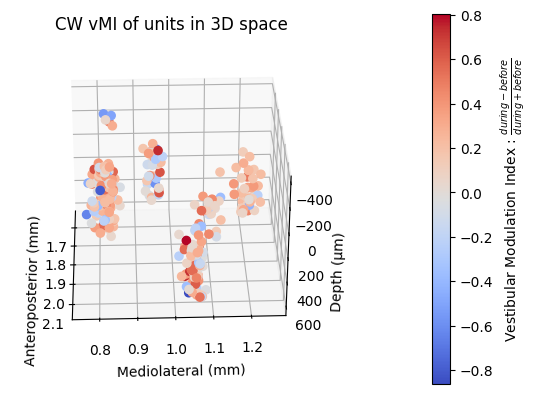

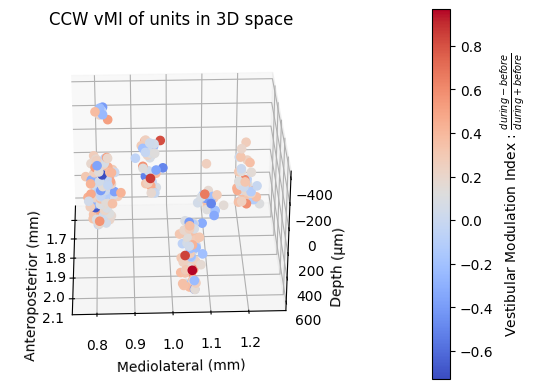

In [17]:
for direction in ['CW', 'CCW']:
    x = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
    y = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
    z = np.concatenate([AllDepth[animal] for animal in AllDepth])
    colors = np.concatenate([vMI[animal]['second'][direction] for animal in vMI])
    colorlabel = r'Vestibular Modulation Index : $\frac{during-before}{during+before}$'
    xlabel = 'Anteroposterior (mm)'
    ylabel = 'Mediolateral (mm)'
    zlabel = 'Depth (µm)'
    title = f"{direction} vMI of units in 3D space"
    filename = f"3D_{direction}_vMI.gif"
    filepath = os.path.join(analyse_path, '3Dmodulation')
    save=True
    show=True
    anim=True


    scatter3D(x,y,z,colors,colorlabel,xlabel,ylabel,zlabel,title,filename,filepath,anim=anim,show=show)

### Projected Scatter

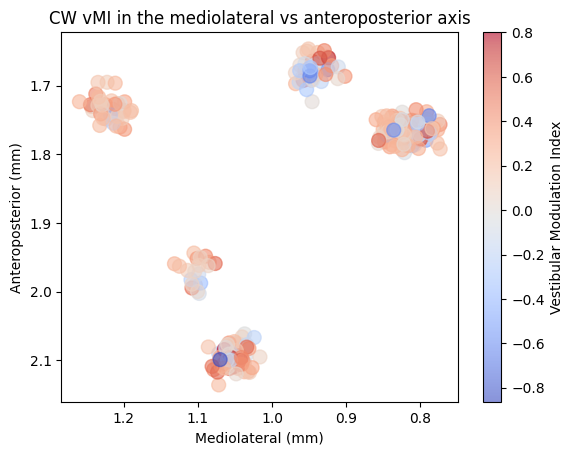

In [18]:
x = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
y = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
colors = np.concatenate([vMI[animal]['second']['CW'] for animal in vMI])

# with load_theme('arctic_light') as theme:
plt.figure()
# Initialiser le graphique de dispersion 3D
plt.scatter(x, y, c=colors, cmap='coolwarm', marker='o', alpha=0.6, s=100)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel('Anteroposterior (mm)')
plt.xlabel('Mediolateral (mm)')

plt.title('CW vMI in the mediolateral vs anteroposterior axis')

plt.colorbar(label='Vestibular Modulation Index')

# Afficher l'animation
plt.show()


# Test

In [19]:
# x = np.linspace(0, 10, 100)
# y = np.sin(x)




# img = Image.open(os.path.join(analyse_path, 'brain.jpeg'))

# fig, ax_main = plt.subplots()

# ax_main.plot(x, y)

# left, width = 0.5, 0.5
# bottom, height = 0.75, 0.2
# rect_image = [left, bottom, width, height]
# ax_image = fig.add_axes(rect_image)


# # Charger l'image et l'afficher
# ax_main.imshow(img)
# # ax_main.axis('off')
# ax_image.plot(x, y)
# # ax_image.axis('off')  # Désactiver les axes pour l'image


# plt.show()


In [20]:
# img = Image.open(os.path.join(analyse_path, 'brain.jpeg'))

# with load_theme("arctic_light"):
#     # Créer une nouvelle figure
#     fig = plt.figure(figsize=(10, 5))

#     ax_image = fig.add_subplot()
#     ax_image.imshow(img)

#     left, width = 0.25, 0.5
#     bottom, height = 0.35, 0.2
#     rect_image = [left, bottom, width, height]
#     ax_plot = fig.add_axes(rect_image)


#     x = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
#     y = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
#     colors = np.concatenate([vMI[animal]['second']['CW'] for animal in vMI])


#     im1 = ax_plot.scatter(x, y, c=colors, cmap='coolwarm', marker='o', alpha=0.6, s=50)
#     ax_plot.set_ylabel('Anteroposterior (mm)')
#     ax_plot.set_xlabel('Mediolateral (mm)')

#     ax_plot.set_title('CW vMI')
#     ax_plot.invert_xaxis()

# fig.colorbar(im1, ax=ax_plot, label='Vestibular Modulation Index')


# plt.show()


In [21]:



# # Charger l'image avec Pillow
# img = Image.open(os.path.join(analyse_path, 'brain.jpeg'))

# with load_theme("arctic_light"):
#     # Créer une nouvelle figure
#     fig = plt.figure(figsize=(10, 5))
#     gs = GridSpec(nrows=1, ncols=2)

#     ax1 = fig.add_subplot(gs[0,1])
#     # Afficher l'image sans les axes
#     ax1.axis('off')
#     ax1.imshow(img)



#     ax2 = fig.add_subplot(gs[0,0])
#     x = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
#     y = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
#     colors = np.concatenate([vMI[animal]['second']['CW'] for animal in vMI])


#     # Initialiser le graphique de dispersion 3D
#     im1 = ax2.scatter(x, y, c=colors, cmap='coolwarm', marker='o', alpha=0.6, s=50)

#     fig.colorbar(im1, ax=ax2, label='Vestibular Modulation Index')

#     #plt.gca().invert_xaxis()
#     ax2.set_ylabel('Anteroposterior (mm)')
#     ax2.set_xlabel('Mediolateral (mm)')

#     ax2.set_title('CW vMI')
#     ax2.invert_xaxis()

# # Afficher la figure
# plt.show()


In [22]:
# with load_theme("arctic_light"):
#     fig = plt.figure()

#     gs = GridSpec(nrows=6, ncols=7)

#     ax = fig.add_subplot(gs[1:4,0:4])
#     ax.plot([1, 2, 3], [4, 5, 6])

# ax3 = fig.add_subplot(gs[0,5:7])
# PSTH(SpikeTimes['animal21_a53d1s1']['second']['CW'][0], xlabel='Time (s)', ylabel='Z-Score', title='PSTH', ax=ax3)
# # Zscore, SEM, edges = get_Zscore(SpikeTimes['animal21_a53d1s1']['second']['CW'][0])
# # ax3.plot(edges[:-1], Zscore)
# # ax3.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.5)

# plt.show()

## vMI and dirMI in another way

In [23]:
# vMIplot = []
# posplot = []
# AllDepthplot = []

# for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
#         for condition in ['second']:
#             for direction in ['CW','CCW']:
#                 for animal in AllData:
#                     vMIplot.extend(AllData[animal]['Statistics_data']['vMI'][condition][direction])
#                     posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['vMI'][condition][direction])))
#                     AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
                
#                 with load_theme('arctic_light'):
#                     plt.figure(figsize=(17, 8))

#                     plt.gca().invert_yaxis()
#                     plt.scatter(vMIplot, AllDepthplot, c=posplot, cmap='coolwarm', s=200, alpha=0.3)
#                     plt.axvline(0, color='gray', linestyle='--')

#                     plt.xlabel("Vestibular Modulation Index\n(during - before) / (during + before)")
#                     plt.ylabel("Depth (µm)")
#                     plt.title(f"{direction} modulation in {pos_title} axis")

#                 plt.colorbar(label=f"{pos_title} position (mm)")
                
#                 direction_modulation_folder_bis = os.path.join(analyse_path, 'Direction_modulation', 'bis')
#                 os.makedirs(direction_modulation_folder_bis, exist_ok=True)
#                 plt.savefig(os.path.join(direction_modulation_folder_bis , f"{direction}_modulation_{pos_title}.png"))

#                 plt.show()
#                 vMIplot = []
#                 posplot = []
#                 AllDepthplot = []

In [24]:
# dirMIplot = []
# posplot = []
# AllDepthplot = []
# mycm = ListedColormap(['blue', 'lawngreen', 'green', 'orange', 'purple', 'red', 'orchid', 'cyan', 'magenta'])

# for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
#         for condition in ['second']:
#             for animal in AllData:
#                 dirMIplot.extend(AllData[animal]['Statistics_data']['dirMI'][condition])
#                 posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['dirMI'][condition])))
#                 AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
            
#             plt.figure(figsize=(17, 8))

#             plt.gca().invert_yaxis()
#             plt.scatter(dirMIplot, AllDepthplot, c=posplot, cmap='coolwarm', s=200, alpha=0.3)
#             plt.colorbar(label=f"{pos_title} position (mm)")
#             plt.axvline(0, color='gray', linestyle='--')

#             plt.xlabel("Direction Modulation Index\n(CW - CCW) / (CW + CCW)")
#             plt.ylabel("Depth (µm)")
#             plt.title(f"CW vs CCW preference in {pos_title} axis")

#             direction_preference_folder_bis = os.path.join(analyse_path, 'Direction_preference', 'bis')
#             os.makedirs(direction_preference_folder_bis, exist_ok=True)
#             plt.savefig(os.path.join(direction_preference_folder_bis , f"{direction}_preference_{pos_title}.png"))

#             plt.show()
#             dirMIplot = []
#             posplot = []
#             AllDepthplot = []


Responding/Non-responding distribution

In [25]:
# phototagged_ones = np.concatenate([modulation[animal]['first'] for animal in AllData])==1
# both_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='both'
# CW_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='CW'
# CCW_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='CCW'
# unmodulated_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='unmodulated'

# for condition in ['first']:
#     phototagged = len(np.where(phototagged_ones)[0])
#     photo_respBOTH = len(np.where((phototagged_ones) & (both_ones))[0])
#     photo_respCW = len(np.where((phototagged_ones) & (CW_ones))[0])
#     photo_respCCW = len(np.where((phototagged_ones) & (CCW_ones))[0])
#     photo_resp = photo_respBOTH + photo_respCCW + photo_respCW
#     photo_notresp = len(np.where((phototagged_ones) & (unmodulated_ones))[0])

#     non_phototagged = np.sum([Nclust[animal] for animal in Nclust]) - phototagged

#     plt.rcParams.update({
#         "text.usetex": False,
#         # "font.family": "Helvetica"
#     })

#     if photo_resp != 0:
#         plt.figure(figsize=(15,5))
#         plt.subplot(1,3,1)

#         labels = ['Photo-tagged', 'Not photo-tagged']
#         valeurs = [phototagged, non_phototagged]
#         print(f"phototagged or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
#         plt.title('Photo-tagging')


#         plt.subplot(1,3,2)
#         labels = ['Responding', 'Not responding']
#         valeurs = [photo_resp, photo_notresp]
#         print(f"Phototagged neurons responding or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation\nof photo-tagged neurons')


#         plt.subplot(1,3,3)
#         labels = ['CW', 'CCW', 'Both']
#         valeurs = [photo_respCW, photo_respCCW, photo_respBOTH]
#         print(f"Modulation of phototagged neurons : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#5FA8FF', '#3385E7', '#1F6ECC'])
#         plt.title('Modulation of photo-tagged neurons')

#         plt.tight_layout()

#         # if Saving_boolean:
#         #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#         #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

#         plt.show()
#         print("\n")
#     elif phototagged != 0:
#         plt.figure(figsize=(15,5))
#         plt.subplot(1,2,1)

#         labels = ['Photo-tagged', 'Not photo-tagged']
#         valeurs = [phototagged, non_phototagged]
#         print(f"phototagged or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
#         plt.title('Photo-tagging')


#         plt.subplot(1,2,2)
#         labels = ['Responding', 'Not responding']
#         valeurs = [photo_resp, photo_notresp]
#         print(f"Phototagged neurons responding or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation\nof photo-tagged neurons')

#         plt.tight_layout()

#         # if Saving_boolean:
#         #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#         #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

#         plt.show()
#         print("\n")
#     else:
#         plt.figure(figsize=(15,5))

#         labels = ['Photo-tagged', 'Not photo-tagged']
#         valeurs = [phototagged, non_phototagged]
#         print(f"phototagged or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
#         plt.title('Photo-tagging')

#         # if Saving_boolean:
#         #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#         #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

#         plt.show()
#         print("\n")








# for condition in ['second']:
#     CWmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'CW' for neuron in range(Nclust[animal])] for animal in AllData]))
#     CCWmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'CCW' for neuron in range(Nclust[animal])] for animal in AllData]))
#     BOTHmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'both' for neuron in range(Nclust[animal])] for animal in AllData]))
#     resp_units = CWmod + CCWmod + BOTHmod
#     nonresp_units = np.sum([Nclust[animal] for animal in Nclust]) - resp_units


#     labels = ['Responding', 'Not responding']
#     valeurs = [resp_units, nonresp_units]

#     plt.rcParams.update({
#         "text.usetex": False,
#         # "font.family": "Helvetica"
#     })

#     if resp_units != 0:
#         plt.figure(figsize=(15,5))
#         plt.subplot(1, 2, 1)
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation')



#         labels_selectivite = ['CW', 'CCW', 'Both']
#         valeurs_selectivite = [CWmod, CCWmod, BOTHmod]

#         print("\n")
#         plt.subplot(1, 2, 2)
#         plt.pie(valeurs_selectivite, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels_selectivite, valeurs_selectivite)], autopct='%1.1f%%', startangle=90, colors=['#5FA8FF', '#3385E7', '#1F6ECC'])
#         # plt.text(1,1, '', ha='center', va='center', fontsize=12, color='red')
#         plt.title('Selectivity of responding neurons')

#         plt.tight_layout()
#     else:
#         plt.figure(figsize=(15,5))
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation')

#     # plt.suptitle(f"{condition} condition", fontsize=16)

#     # if Saving_boolean:
#     #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#     #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_{condition}_condition.png"))
    
#     plt.show()